In [2]:
%matplotlib inline
import pandas as pd # Далее идет импорт библиотек...
import numpy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot') # Стиль отображения графиков
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from keras import losses

Using TensorFlow backend.


In [3]:
import os
os.chdir('C:/Users/Admin/Desktop/КЕЙС/nn') # Путь куда это все будет сохраняться на моем пк

In [4]:
file_with_PRODAJI = 'C:/Users/Admin/Desktop/КЕЙС/data_science_case-data/sales.tsv' # Путь до датасетов на моем пк
file_with_POKUPATELI = 'C:/Users/Admin/Desktop/КЕЙС/data_science_case-data/customers.tsv' # Путь до датасетов на моем пк

In [5]:
df1 = pd.read_csv(file_with_PRODAJI, delimiter='\t', encoding='utf-8')    # Читаем датасет
df1.fillna(0, inplace=True)                                               # Избавляемся от NaN
df2 = pd.read_csv(file_with_POKUPATELI, delimiter='\t', encoding='utf-8')
df2.fillna(0, inplace=True)

In [6]:
df1['year'] = df1.year.map(str) + '-' + df1.month.map(str) # Соединяем стобцы 'year' и 'month' в один
df1.drop('month', axis=1, inplace=True)                    # Сбрасываем из датасета не нужный столбец 'month'
df1.tail()                                                 # Проверяем конец датасета на наличие всяких битых приколов и пояснеий

year    location ira product_category           brand   sku_id  \
1724  2019-6  Pirate Bay  PB        Lollipops     Chupa Chups  sku #97   
1725  2019-6     Village  VL       Chocolates  Ferrero Rocher  sku #30   
1726  2019-6     Village  VL       Chocolates  Ferrero Rocher  sku #46   
1727  2019-6     Village  VL       Chocolates       Toblerone  sku #25   
1728  2019-6     Village  VL       Chocolates       Toblerone  sku #73   

      item_per_bundle     shape with_alcohol  filling  volume     price  
1724                1     Round           No     Nuts  5790.0  1.316449  
1725                1  Standart           No  Nothing   394.0  1.251254  
1726                1  Standart           No  Nothing   197.0  1.251254  
1727                1  Standart           No  Nothing    49.0  1.251254  
1728                1  Standart           No  Nothing    49.0  1.251254

In [11]:
df_for_PB = df1.loc[(df1['location'] == 'Pirate Bay')] # Обозначаем локацию в которой будем работать
df_for_PB.drop('location', axis=1, inplace=True)       # Сбрасываем все ненужные столбцы данных, ОСОБЕННО str
df_for_PB.drop('ira', axis=1, inplace=True)
df_for_PB.drop('product_category', axis=1, inplace=True)
df_for_PB.drop('brand', axis=1, inplace=True)
df_for_PB.drop('item_per_bundle', axis=1, inplace=True)
df_for_PB.drop('shape', axis=1, inplace=True)
df_for_PB.drop('with_alcohol', axis=1, inplace=True)
df_for_PB.drop('filling', axis=1, inplace=True)
df_for_PB.drop('price', axis=1, inplace=True)    

In [12]:
# -SKU#15-

In [65]:
PB_sku15 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #15')] # Настраиваем датасет на первый из доступных sku
PB_sku15.drop('sku_id', axis=1, inplace=True)                # Затем сбрасываем столбец с ним
#PB_sku15.iloc[:,1].plot()                                   # Строим график продаж на известные нам даты
NN_PB_sku15 = pd.DataFrame()                                 # Создаем новый дата сет для нейронки

for i in range(12,0,-1):                                     # Преобразуем данные для предсказаний нейронной сети
    NN_PB_sku15['t-' + str(i)] = PB_sku15.iloc[:,1].shift(i) # Сдвигаем наши наблюдения
    
NN_PB_sku15['t'] = PB_sku15.iloc[:,1].values                 # Записываем исходный ряд в последний столбец
#print(NN_PB_sku15.head(13))                                 # Проверяем

new_NN_PB_sku15 = NN_PB_sku15[12:]                           # Отрезаем первые 12 строк, чтобы избавиться от NaN
#new_NN_PB_sku15.head()                                      # Проверяем что сделали

y = new_NN_PB_sku15['t']                                     # Разделям у и х. у - отклик
x = new_NN_PB_sku15.drop('t', axis=1)                        # х - предикторы, после отбрасывания последнего столбца

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train = x[:15]                                             # Разделяем на обучающую и тестовую выборки
y_train = y[:15]                                             # Для тестовой отрезаем последние наблюдения, в нашем случае
x_test = x[15:]                                              # это 3 месяца, на них и будет основываться наш прогноз
y_test = y[15:]

#print(new_NN_PB_sku15.shape)                                # Определяем размерности
#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
#print(x_train.head(5))                                      # Проверяем

x_train = x_train.values                                     # Преобразуем в матрицы numpy чтобы их смог прочесть keras
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

# NN

model = Sequential()
model.add(Dense(6, input_dim=12, activation='relu'))        # Ставим 6 нейронов, по 12 димов, т.к у нас 12 месяцев, активируем relu
model.add(Dense(1, activation='linear'))                    # Поскольку у нас задача регрессии, то берем линейную функцию, выходной нейрон 1
model.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape']) # потери mse, оптимайзер adam, метрика по mape
model.fit(x_train, y_train, epochs=300, batch_size=None)    # Модель тренеровки, 300 эпох, снимаю батчи, т.к данных не много

Epoch 1/300
15/15 [==============================] - 1s 90ms/step - loss: 4384044.5000 - mean_absolute_percentage_error: 52.0734
Epoch 2/300
15/15 [==============================] - 0s 67us/step - loss: 4074093.0000 - mean_absolute_percentage_error: 50.0878
Epoch 3/300
15/15 [==============================] - 0s 200us/step - loss: 3781683.2500 - mean_absolute_percentage_error: 48.3246
Epoch 4/300
15/15 [==============================] - 0s 134us/step - loss: 3506747.7500 - mean_absolute_percentage_error: 46.6284
Epoch 5/300
15/15 [==============================] - 0s 133us/step - loss: 3247779.2500 - mean_absolute_percentage_error: 44.8884
Epoch 6/300
15/15 [==============================] - 0s 199us/step - loss: 3005342.5000 - mean_absolute_percentage_error: 43.1641
Epoch 7/300
15/15 [==============================] - 0s 200us/step - loss: 2779357.7500 - mean_absolute_percentage_error: 41.4580
Epoch 8/300
15/15 [==============================] - 0s 199us/step - loss: 2569681.5000 - me

Epoch 64/300
15/15 [==============================] - 0s 133us/step - loss: 904480.6875 - mean_absolute_percentage_error: 20.1860
Epoch 65/300
15/15 [==============================] - 0s 532us/step - loss: 901946.6250 - mean_absolute_percentage_error: 20.1818
Epoch 66/300
15/15 [==============================] - 0s 266us/step - loss: 899517.8750 - mean_absolute_percentage_error: 20.1761
Epoch 67/300
15/15 [==============================] - 0s 400us/step - loss: 897174.1875 - mean_absolute_percentage_error: 20.1689
Epoch 68/300
15/15 [==============================] - 0s 198us/step - loss: 894895.8125 - mean_absolute_percentage_error: 20.1604
Epoch 69/300
15/15 [==============================] - 0s 267us/step - loss: 892667.6875 - mean_absolute_percentage_error: 20.1503
Epoch 70/300
15/15 [==============================] - 0s 199us/step - loss: 890474.0000 - mean_absolute_percentage_error: 20.1389
Epoch 71/300
15/15 [==============================] - 0s 133us/step - loss: 888289.3125 - 

Epoch 127/300
15/15 [==============================] - 0s 199us/step - loss: 791203.1250 - mean_absolute_percentage_error: 19.3667
Epoch 128/300
15/15 [==============================] - 0s 133us/step - loss: 789825.7500 - mean_absolute_percentage_error: 19.3520
Epoch 129/300
15/15 [==============================] - 0s 133us/step - loss: 788454.0000 - mean_absolute_percentage_error: 19.3370
Epoch 130/300
15/15 [==============================] - 0s 133us/step - loss: 787083.3125 - mean_absolute_percentage_error: 19.3217
Epoch 131/300
15/15 [==============================] - 0s 199us/step - loss: 785723.6250 - mean_absolute_percentage_error: 19.3061
Epoch 132/300
15/15 [==============================] - 0s 133us/step - loss: 784369.2500 - mean_absolute_percentage_error: 19.2902
Epoch 133/300
15/15 [==============================] - 0s 133us/step - loss: 783020.1250 - mean_absolute_percentage_error: 19.2740
Epoch 134/300
15/15 [==============================] - 0s 199us/step - loss: 781676

Epoch 190/300
15/15 [==============================] - 0s 133us/step - loss: 712742.6250 - mean_absolute_percentage_error: 18.2206
Epoch 191/300
15/15 [==============================] - 0s 133us/step - loss: 711611.6250 - mean_absolute_percentage_error: 18.2012
Epoch 192/300
15/15 [==============================] - 0s 266us/step - loss: 710484.0000 - mean_absolute_percentage_error: 18.1818
Epoch 193/300
15/15 [==============================] - 0s 199us/step - loss: 709359.8125 - mean_absolute_percentage_error: 18.1623
Epoch 194/300
15/15 [==============================] - 0s 199us/step - loss: 708238.8750 - mean_absolute_percentage_error: 18.1429
Epoch 195/300
15/15 [==============================] - 0s 133us/step - loss: 707121.4375 - mean_absolute_percentage_error: 18.1235
Epoch 196/300
15/15 [==============================] - 0s 66us/step - loss: 706007.2500 - mean_absolute_percentage_error: 18.1040
Epoch 197/300
15/15 [==============================] - 0s 199us/step - loss: 704896.

Epoch 253/300
15/15 [==============================] - 0s 133us/step - loss: 648098.3750 - mean_absolute_percentage_error: 17.0661
Epoch 254/300
15/15 [==============================] - 0s 133us/step - loss: 647179.0625 - mean_absolute_percentage_error: 17.0519
Epoch 255/300
15/15 [==============================] - 0s 266us/step - loss: 646262.9375 - mean_absolute_percentage_error: 17.0377
Epoch 256/300
15/15 [==============================] - 0s 266us/step - loss: 645350.0000 - mean_absolute_percentage_error: 17.0235
Epoch 257/300
15/15 [==============================] - 0s 133us/step - loss: 644440.3125 - mean_absolute_percentage_error: 17.0093
Epoch 258/300
15/15 [==============================] - 0s 133us/step - loss: 643534.0000 - mean_absolute_percentage_error: 16.9952
Epoch 259/300
15/15 [==============================] - 0s 132us/step - loss: 642630.6250 - mean_absolute_percentage_error: 16.9810
Epoch 260/300
15/15 [==============================] - 0s 199us/step - loss: 641728

In [17]:
scores = model.evaluate(x_test, y_test) # Проверяем качество на тестовом множестве
y_pred = model.predict(x_test)          # Задаем y_pred

def smape(y_test, y_pred):
    return 100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))) # Формула SMAPE

print(smape(y_test, y_pred))
# Подсчитали SMAPE 

3/3 [==============================] - 0s 23ms/step
289.20125048968544


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


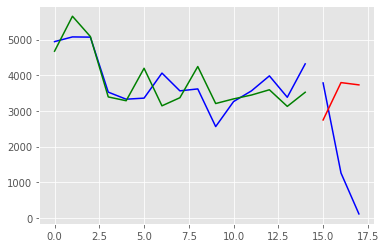

In [18]:
predictions = model.predict(x_test)                # Вычисляем прогноз
predictions_train = model.predict(x_train)         # Подгонка

print(x_train.shape)                               # Еще раз все проверяем
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(NN_PB_sku15.shape)

x2 = numpy.arange(0, 15, 1)                        # задаем наши числа 
x3 = numpy.arange(15, 18, 1)

plt.plot(x2, y_train, color='blue')                # обучающая
plt.plot(x2, predictions_train, color='green')     # подгонка
plt.plot(x3, y_test, color='blue')                 # тестовая
plt.plot(x3, predictions, color='red')             # прогноз

# redline - прогноз, greenline - подгонка

# ДАЛЬШЕ ПО КОДУ, ВСE ПОВТОРЯЕТСЯ

In [19]:
print(predictions)

[[2747.3767]
 [3795.4995]
 [3731.4287]]


In [407]:
# -SKU#16-

In [84]:
PB_sku16 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #16')]
PB_sku16.drop('sku_id', axis=1, inplace=True)
#PB_sku16.iloc[:,1].plot()

NN_PB_sku16 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku16['t-' + str(i)] = PB_sku16.iloc[:,1].shift(i)
    
NN_PB_sku16['t'] = PB_sku16.iloc[:,1].values
#print(NN_PB_sku16.head(13))

new_NN_PB_sku16 = NN_PB_sku16[12:]
new_NN_PB_sku16.head()

y1 = new_NN_PB_sku16['t']
x1 = new_NN_PB_sku16.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train1 = x1[:15]
y_train1 = y1[:15]
x_test1 = x1[15:]
y_test1 = y1[15:]

#print(new_NN_PB_sku16.shape)
#print(x_train1.shape)
#print(y_train1.shape)
#print(x_test1.shape)
#print(y_test1.shape)
#print(x_train1.head(5))

x_train1 = x_train1.values
y_train1 = y_train1.values
x_test1 = x_test1.values
y_test1 = y_test1.values

# NN

model1 = Sequential()
model1.add(Dense(6, input_dim=12, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model1.fit(x_train1, y_train1, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 2s 119ms/step - loss: 22384792.0000 - mean_absolute_percentage_error: 68.6262
Epoch 2/300
15/15 [==============================] - 0s 133us/step - loss: 21229208.0000 - mean_absolute_percentage_error: 66.7034
Epoch 3/300
15/15 [==============================] - 0s 132us/step - loss: 19941688.0000 - mean_absolute_percentage_error: 64.4873
Epoch 4/300
15/15 [==============================] - 0s 134us/step - loss: 18629672.0000 - mean_absolute_percentage_error: 62.1395
Epoch 5/300
15/15 [==============================] - 0s 133us/step - loss: 17329636.0000 - mean_absolute_percentage_error: 59.7152
Epoch 6/300
15/15 [==============================] - 0s 200us/step - loss: 16056681.0000 - mean_absolute_percentage_error: 57.3524
Epoch 7/300
15/15 [==============================] - 0s 133us/step - loss: 14831185.0000 - mean_absolute_percentage_error: 55.0732
Epoch 8/300
15/15 [==============================] - 0s 200us/step - loss: 13642679

Epoch 64/300
15/15 [==============================] - 0s 133us/step - loss: 2655325.2500 - mean_absolute_percentage_error: 18.8959
Epoch 65/300
15/15 [==============================] - 0s 333us/step - loss: 2647305.0000 - mean_absolute_percentage_error: 18.9584
Epoch 66/300
15/15 [==============================] - 0s 200us/step - loss: 2639800.7500 - mean_absolute_percentage_error: 19.0134
Epoch 67/300
15/15 [==============================] - 0s 133us/step - loss: 2632681.0000 - mean_absolute_percentage_error: 19.0608
Epoch 68/300
15/15 [==============================] - 0s 266us/step - loss: 2625810.2500 - mean_absolute_percentage_error: 19.1003
Epoch 69/300
15/15 [==============================] - 0s 199us/step - loss: 2619078.7500 - mean_absolute_percentage_error: 19.1320
Epoch 70/300
15/15 [==============================] - 0s 1ms/step - loss: 2612399.5000 - mean_absolute_percentage_error: 19.1559
Epoch 71/300
15/15 [==============================] - 0s 200us/step - loss: 2605860.0

Epoch 127/300
15/15 [==============================] - 0s 199us/step - loss: 2197136.7500 - mean_absolute_percentage_error: 17.5854
Epoch 128/300
15/15 [==============================] - 0s 200us/step - loss: 2189626.2500 - mean_absolute_percentage_error: 17.5560
Epoch 129/300
15/15 [==============================] - 0s 266us/step - loss: 2182059.0000 - mean_absolute_percentage_error: 17.5274
Epoch 130/300
15/15 [==============================] - 0s 266us/step - loss: 2174490.7500 - mean_absolute_percentage_error: 17.4997
Epoch 131/300
15/15 [==============================] - 0s 199us/step - loss: 2166869.7500 - mean_absolute_percentage_error: 17.4727
Epoch 132/300
15/15 [==============================] - 0s 134us/step - loss: 2159226.2500 - mean_absolute_percentage_error: 17.4464
Epoch 133/300
15/15 [==============================] - 0s 2ms/step - loss: 2151931.0000 - mean_absolute_percentage_error: 17.4213
Epoch 134/300
15/15 [==============================] - 0s 133us/step - loss: 2

Epoch 190/300
15/15 [==============================] - 0s 332us/step - loss: 1725664.6250 - mean_absolute_percentage_error: 15.6432
Epoch 191/300
15/15 [==============================] - 0s 199us/step - loss: 1718446.7500 - mean_absolute_percentage_error: 15.6162
Epoch 192/300
15/15 [==============================] - 0s 266us/step - loss: 1711297.2500 - mean_absolute_percentage_error: 15.5849
Epoch 193/300
15/15 [==============================] - 0s 133us/step - loss: 1703995.2500 - mean_absolute_percentage_error: 15.5491
Epoch 194/300
15/15 [==============================] - 0s 133us/step - loss: 1696763.6250 - mean_absolute_percentage_error: 15.5099
Epoch 195/300
15/15 [==============================] - 0s 132us/step - loss: 1689649.2500 - mean_absolute_percentage_error: 15.4743
Epoch 196/300
15/15 [==============================] - 0s 200us/step - loss: 1682433.6250 - mean_absolute_percentage_error: 15.4420
Epoch 197/300
15/15 [==============================] - 0s 133us/step - loss:

15/15 [==============================] - 0s 267us/step - loss: 1312322.2500 - mean_absolute_percentage_error: 13.5026
Epoch 253/300
15/15 [==============================] - 0s 199us/step - loss: 1306430.3750 - mean_absolute_percentage_error: 13.4677
Epoch 254/300
15/15 [==============================] - 0s 133us/step - loss: 1300266.6250 - mean_absolute_percentage_error: 13.4393
Epoch 255/300
15/15 [==============================] - 0s 133us/step - loss: 1294421.3750 - mean_absolute_percentage_error: 13.4180
Epoch 256/300
15/15 [==============================] - 0s 133us/step - loss: 1288732.2500 - mean_absolute_percentage_error: 13.3919
Epoch 257/300
15/15 [==============================] - 0s 267us/step - loss: 1282971.6250 - mean_absolute_percentage_error: 13.3608
Epoch 258/300
15/15 [==============================] - 0s 199us/step - loss: 1277147.1250 - mean_absolute_percentage_error: 13.3250
Epoch 259/300
15/15 [==============================] - 0s 134us/step - loss: 1271262.0000 

In [85]:
scores1 = model1.evaluate(x_test1, y_test1)
y_pred1 = model1.predict(x_test1)

def smape(y_test1, y_pred1):
    return 100/len(y_test1) * np.sum(2 * np.abs(y_pred1 - y_test1) / (np.abs(y_test1) + np.abs(y_pred1)))

print(smape(y_test1, y_pred1))
# Подсчитали SMAPE 

3/3 [==============================] - 1s 230ms/step
25.736800932882094


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


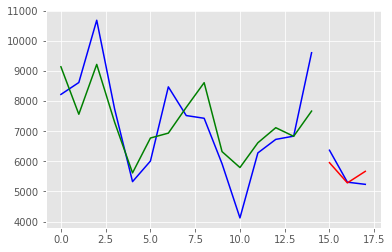

In [86]:
predictions1 = model1.predict(x_test1)
predictions_train1 = model1.predict(x_train1)

print(x_train1.shape)
print(y_train1.shape)
print(x_test1.shape)
print(y_test1.shape)
print(NN_PB_sku16.shape)

x2_1 = numpy.arange(0, 15, 1)
x3_1 = numpy.arange(15, 18, 1)

plt.plot(x2_1, y_train1, color='blue')
plt.plot(x2_1, predictions_train1, color='green')
plt.plot(x3_1, y_test1, color='blue')
plt.plot(x3_1, predictions1, color='red')

# redline - прогноз, greenline - подгонка

In [87]:
print(predictions1)

[[5957.9424]
 [5286.196 ]
 [5670.16  ]]


In [ ]:
# -SKU#22-

In [104]:
PB_sku22 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #22')]
PB_sku22.drop('sku_id', axis=1, inplace=True)
#PB_sku22.iloc[:,1].plot()

NN_PB_sku22 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku22['t-' + str(i)] = PB_sku22.iloc[:,1].shift(i)
    
NN_PB_sku22['t'] = PB_sku22.iloc[:,1].values
#print(NN_PB_sku22.head(13))

new_NN_PB_sku22 = NN_PB_sku22[12:]
#new_NN_PB_sku22.head()

y2 = new_NN_PB_sku22['t']
x2 = new_NN_PB_sku22.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train2 = x2[:15]
y_train2 = y2[:15]
x_test2 = x2[15:]
y_test2 = y2[15:]

#print(new_NN_PB_sku22.shape)
#print(x_train2.shape)
#print(y_train2.shape)
#print(x_test2.shape)
#print(y_test2.shape)
#print(x_train2.head(5))

x_train2 = x_train2.values
y_train2 = y_train2.values
x_test2 = x_test2.values
y_test2 = y_test2.values

# NN

model2 = Sequential()
model2.add(Dense(6, input_dim=12, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model2.fit(x_train2, y_train2, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 2s 143ms/step - loss: 6842888.5000 - mean_absolute_percentage_error: 20.1579
Epoch 2/300
15/15 [==============================] - 0s 133us/step - loss: 6364349.5000 - mean_absolute_percentage_error: 19.5403
Epoch 3/300
15/15 [==============================] - 0s 200us/step - loss: 5983376.0000 - mean_absolute_percentage_error: 19.0579
Epoch 4/300
15/15 [==============================] - 0s 266us/step - loss: 5698547.5000 - mean_absolute_percentage_error: 18.6982
Epoch 5/300
15/15 [==============================] - 0s 200us/step - loss: 5505364.5000 - mean_absolute_percentage_error: 18.3522
Epoch 6/300
15/15 [==============================] - 0s 200us/step - loss: 5398308.5000 - mean_absolute_percentage_error: 18.1575
Epoch 7/300
15/15 [==============================] - 0s 199us/step - loss: 5354046.0000 - mean_absolute_percentage_error: 18.0412
Epoch 8/300
15/15 [==============================] - 0s 200us/step - loss: 5359736.5000 - 

Epoch 64/300
15/15 [==============================] - 0s 133us/step - loss: 4554973.0000 - mean_absolute_percentage_error: 16.5383
Epoch 65/300
15/15 [==============================] - 0s 199us/step - loss: 4539007.0000 - mean_absolute_percentage_error: 16.5033
Epoch 66/300
15/15 [==============================] - 0s 267us/step - loss: 4523106.0000 - mean_absolute_percentage_error: 16.4698
Epoch 67/300
15/15 [==============================] - 0s 133us/step - loss: 4507108.5000 - mean_absolute_percentage_error: 16.4376
Epoch 68/300
15/15 [==============================] - 0s 199us/step - loss: 4491006.0000 - mean_absolute_percentage_error: 16.4065
Epoch 69/300
15/15 [==============================] - 0s 199us/step - loss: 4474814.0000 - mean_absolute_percentage_error: 16.3765
Epoch 70/300
15/15 [==============================] - 0s 199us/step - loss: 4458568.5000 - mean_absolute_percentage_error: 16.3474
Epoch 71/300
15/15 [==============================] - 0s 266us/step - loss: 4442313

Epoch 127/300
15/15 [==============================] - 0s 199us/step - loss: 3559309.2500 - mean_absolute_percentage_error: 14.5982
Epoch 128/300
15/15 [==============================] - 0s 200us/step - loss: 3544167.0000 - mean_absolute_percentage_error: 14.5707
Epoch 129/300
15/15 [==============================] - 0s 133us/step - loss: 3528996.2500 - mean_absolute_percentage_error: 14.5429
Epoch 130/300
15/15 [==============================] - 0s 198us/step - loss: 3513907.5000 - mean_absolute_percentage_error: 14.5152
Epoch 131/300
15/15 [==============================] - 0s 266us/step - loss: 3498792.5000 - mean_absolute_percentage_error: 14.4873
Epoch 132/300
15/15 [==============================] - 0s 200us/step - loss: 3483704.2500 - mean_absolute_percentage_error: 14.4594
Epoch 133/300
15/15 [==============================] - 0s 465us/step - loss: 3468696.5000 - mean_absolute_percentage_error: 14.4314
Epoch 134/300
15/15 [==============================] - 0s 199us/step - loss:

Epoch 190/300
15/15 [==============================] - 0s 1ms/step - loss: 2663308.5000 - mean_absolute_percentage_error: 12.7814
Epoch 191/300
15/15 [==============================] - 0s 199us/step - loss: 2650192.5000 - mean_absolute_percentage_error: 12.7516
Epoch 192/300
15/15 [==============================] - 0s 200us/step - loss: 2637083.7500 - mean_absolute_percentage_error: 12.7217
Epoch 193/300
15/15 [==============================] - 0s 266us/step - loss: 2624046.5000 - mean_absolute_percentage_error: 12.6918
Epoch 194/300
15/15 [==============================] - 0s 199us/step - loss: 2611048.7500 - mean_absolute_percentage_error: 12.6619
Epoch 195/300
15/15 [==============================] - 0s 200us/step - loss: 2598088.7500 - mean_absolute_percentage_error: 12.6319
Epoch 196/300
15/15 [==============================] - 0s 132us/step - loss: 2585167.7500 - mean_absolute_percentage_error: 12.6019
Epoch 197/300
15/15 [==============================] - 0s 199us/step - loss: 2

Epoch 253/300
15/15 [==============================] - 0s 266us/step - loss: 1919738.8750 - mean_absolute_percentage_error: 10.8557
Epoch 254/300
15/15 [==============================] - 0s 266us/step - loss: 1909413.8750 - mean_absolute_percentage_error: 10.8247
Epoch 255/300
15/15 [==============================] - 0s 131us/step - loss: 1899122.6250 - mean_absolute_percentage_error: 10.7936
Epoch 256/300
15/15 [==============================] - 0s 199us/step - loss: 1888880.0000 - mean_absolute_percentage_error: 10.7625
Epoch 257/300
15/15 [==============================] - 0s 201us/step - loss: 1878704.5000 - mean_absolute_percentage_error: 10.7314
Epoch 258/300
15/15 [==============================] - 0s 133us/step - loss: 1868579.8750 - mean_absolute_percentage_error: 10.7004
Epoch 259/300
15/15 [==============================] - 0s 133us/step - loss: 1858504.2500 - mean_absolute_percentage_error: 10.6693
Epoch 260/300
15/15 [==============================] - 0s 133us/step - loss:

In [105]:
scores2 = model2.evaluate(x_test2, y_test2)
y_pred2 = model2.predict(x_test2)

def smape(y_test2, y_pred2):
    return 100/len(y_test2) * np.sum(2 * np.abs(y_pred2 - y_test2) / (np.abs(y_test2) + np.abs(y_pred2)))

print(smape(y_test2, y_pred2))
# Подсчитали SMAPE

3/3 [==============================] - 1s 261ms/step
72.13078395688805


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


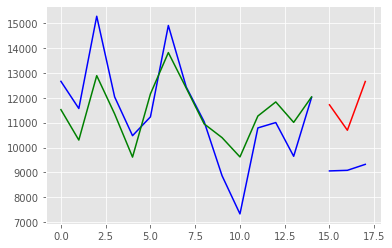

In [106]:
predictions2 = model2.predict(x_test2)
predictions_train2 = model2.predict(x_train2)

print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)
print(NN_PB_sku22.shape)

x2_2 = numpy.arange(0, 15, 1)
x3_2 = numpy.arange(15, 18, 1)

plt.plot(x2_2, y_train2, color='blue')
plt.plot(x2_2, predictions_train2, color='green')
plt.plot(x3_2, y_test2, color='blue')
plt.plot(x3_2, predictions2, color='red')

# redline - прогноз, greenline - подгонка

In [107]:
print(predictions2)

[[11716.551]
 [10694.969]
 [12652.895]]


In [ ]:
# -SKU#25-

In [111]:
PB_sku25 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #25')]
PB_sku25.drop('sku_id', axis=1, inplace=True)
#PB_sku25.iloc[:,1].plot()

NN_PB_sku25 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku25['t-' + str(i)] = PB_sku25.iloc[:,1].shift(i)
    
NN_PB_sku25['t'] = PB_sku25.iloc[:,1].values
#print(NN_PB_sku25.head(13))

new_NN_PB_sku25 = NN_PB_sku25[12:]
#new_NN_PB_sku25.head()

y3 = new_NN_PB_sku25['t']
x3 = new_NN_PB_sku25.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train3 = x3[:15]
y_train3 = y3[:15]
x_test3 = x3[15:]
y_test3 = y3[15:]

#print(new_NN_PB_sku25.shape)
#print(x_train3.shape)
#print(y_train3.shape)
#print(x_test3.shape)
#print(y_test3.shape)
#print(x_train3.head(5))

x_train3 = x_train3.values
y_train3 = y_train3.values
x_test3 = x_test3.values
y_test3 = y_test3.values

# NN

model3 = Sequential()
model3.add(Dense(6, input_dim=12, activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model3.fit(x_train3, y_train3, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 2s 145ms/step - loss: 1363071.2500 - mean_absolute_percentage_error: 29.5711
Epoch 2/300
15/15 [==============================] - 0s 133us/step - loss: 1286108.6250 - mean_absolute_percentage_error: 29.4003
Epoch 3/300
15/15 [==============================] - 0s 133us/step - loss: 1215467.8750 - mean_absolute_percentage_error: 29.2296
Epoch 4/300
15/15 [==============================] - 0s 266us/step - loss: 1149496.8750 - mean_absolute_percentage_error: 29.0436
Epoch 5/300
15/15 [==============================] - 0s 268us/step - loss: 1086994.8750 - mean_absolute_percentage_error: 28.8295
Epoch 6/300
15/15 [==============================] - 0s 133us/step - loss: 1031183.1875 - mean_absolute_percentage_error: 28.6017
Epoch 7/300
15/15 [==============================] - 0s 133us/step - loss: 983164.0625 - mean_absolute_percentage_error: 28.3583
Epoch 8/300
15/15 [==============================] - 0s 265us/step - loss: 944751.8750 - me

Epoch 65/300
15/15 [==============================] - 0s 332us/step - loss: 470151.2812 - mean_absolute_percentage_error: 22.3556
Epoch 66/300
15/15 [==============================] - 0s 199us/step - loss: 463788.4688 - mean_absolute_percentage_error: 22.1696
Epoch 67/300
15/15 [==============================] - 0s 266us/step - loss: 457506.0312 - mean_absolute_percentage_error: 21.9833
Epoch 68/300
15/15 [==============================] - 0s 199us/step - loss: 451309.0625 - mean_absolute_percentage_error: 21.7978
Epoch 69/300
15/15 [==============================] - 0s 199us/step - loss: 445197.4062 - mean_absolute_percentage_error: 21.6136
Epoch 70/300
15/15 [==============================] - 0s 199us/step - loss: 439167.5938 - mean_absolute_percentage_error: 21.4315
Epoch 71/300
15/15 [==============================] - 0s 199us/step - loss: 433532.1250 - mean_absolute_percentage_error: 21.2618
Epoch 72/300
15/15 [==============================] - 0s 199us/step - loss: 427927.8750 - 

Epoch 128/300
15/15 [==============================] - 0s 200us/step - loss: 213435.0625 - mean_absolute_percentage_error: 13.7548
Epoch 129/300
15/15 [==============================] - 0s 200us/step - loss: 211215.6719 - mean_absolute_percentage_error: 13.6576
Epoch 130/300
15/15 [==============================] - 0s 198us/step - loss: 209075.9062 - mean_absolute_percentage_error: 13.5608
Epoch 131/300
15/15 [==============================] - 0s 133us/step - loss: 206938.1406 - mean_absolute_percentage_error: 13.4661
Epoch 132/300
15/15 [==============================] - 0s 333us/step - loss: 204864.1406 - mean_absolute_percentage_error: 13.3740
Epoch 133/300
15/15 [==============================] - 0s 332us/step - loss: 202842.2812 - mean_absolute_percentage_error: 13.2815
Epoch 134/300
15/15 [==============================] - 0s 135us/step - loss: 200848.5000 - mean_absolute_percentage_error: 13.1884
Epoch 135/300
15/15 [==============================] - 0s 133us/step - loss: 198882

Epoch 191/300
15/15 [==============================] - 0s 132us/step - loss: 127726.7031 - mean_absolute_percentage_error: 9.9538
Epoch 192/300
15/15 [==============================] - 0s 266us/step - loss: 126880.4297 - mean_absolute_percentage_error: 9.9209
Epoch 193/300
15/15 [==============================] - 0s 133us/step - loss: 126034.9531 - mean_absolute_percentage_error: 9.8920
Epoch 194/300
15/15 [==============================] - 0s 266us/step - loss: 125214.4688 - mean_absolute_percentage_error: 9.8558
Epoch 195/300
15/15 [==============================] - 0s 266us/step - loss: 124393.4141 - mean_absolute_percentage_error: 9.8237
Epoch 196/300
15/15 [==============================] - 0s 266us/step - loss: 123595.8906 - mean_absolute_percentage_error: 9.7956
Epoch 197/300
15/15 [==============================] - 0s 333us/step - loss: 122775.5469 - mean_absolute_percentage_error: 9.7592
Epoch 198/300
15/15 [==============================] - 0s 199us/step - loss: 121977.4609 -

Epoch 255/300
15/15 [==============================] - 0s 133us/step - loss: 84904.3672 - mean_absolute_percentage_error: 8.0066
Epoch 256/300
15/15 [==============================] - 0s 199us/step - loss: 84367.6953 - mean_absolute_percentage_error: 7.9816
Epoch 257/300
15/15 [==============================] - 0s 332us/step - loss: 83841.6250 - mean_absolute_percentage_error: 7.9570
Epoch 258/300
15/15 [==============================] - 0s 199us/step - loss: 83315.5938 - mean_absolute_percentage_error: 7.9325
Epoch 259/300
15/15 [==============================] - 0s 2ms/step - loss: 82789.8750 - mean_absolute_percentage_error: 7.9080
Epoch 260/300
15/15 [==============================] - 0s 199us/step - loss: 82263.8516 - mean_absolute_percentage_error: 7.8836
Epoch 261/300
15/15 [==============================] - 0s 200us/step - loss: 81759.8984 - mean_absolute_percentage_error: 7.8597
Epoch 262/300
15/15 [==============================] - 0s 133us/step - loss: 81232.2188 - mean_abso

In [112]:
scores3 = model3.evaluate(x_test3, y_test3)
y_pred3 = model3.predict(x_test3)

def smape(y_test3, y_pred3):
    return 100/len(y_test3) * np.sum(2 * np.abs(y_pred3 - y_test3) / (np.abs(y_test3) + np.abs(y_pred3)))

print(smape(y_test3, y_pred3))
# Подсчитали SMAPE

3/3 [==============================] - 1s 283ms/step
41.79482430721117


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


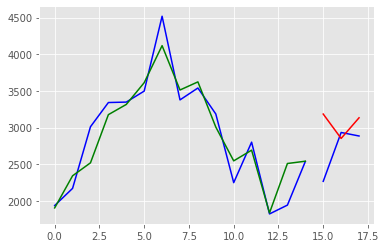

In [113]:
predictions3 = model3.predict(x_test3)
predictions_train3 = model3.predict(x_train3)

print(x_train3.shape)
print(y_train3.shape)
print(x_test3.shape)
print(y_test3.shape)
print(NN_PB_sku25.shape)

x2_3 = numpy.arange(0, 15, 1)
x3_3 = numpy.arange(15, 18, 1)

plt.plot(x2_3, y_train3, color='blue')
plt.plot(x2_3, predictions_train3, color='green')
plt.plot(x3_3, y_test3, color='blue')
plt.plot(x3_3, predictions3, color='red')

# redline - прогноз, greenline - подгонка

In [114]:
print(predictions3)

[[3185.0603]
 [2852.8916]
 [3133.9812]]


In [436]:
# -SKU#28-

In [124]:
PB_sku28 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #28')]
PB_sku28.drop('sku_id', axis=1, inplace=True)
#PB_sku28.iloc[:,1].plot()

NN_PB_sku28 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku28['t-' + str(i)] = PB_sku28.iloc[:,1].shift(i)
    
NN_PB_sku28['t'] = PB_sku28.iloc[:,1].values
#print(NN_PB_sku28.head(13))

new_NN_PB_sku28 = NN_PB_sku28[12:]
#new_NN_PB_sku28.head()

y4 = new_NN_PB_sku28['t']
x4 = new_NN_PB_sku28.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train4 = x4[:15]
y_train4 = y4[:15]
x_test4 = x4[15:]
y_test4 = y4[15:]

#print(new_NN_PB_sku28.shape)
#print(x_train4.shape)
#print(y_train4.shape)
#print(x_test4.shape)
#print(y_test4.shape)
#print(x_train4.head(5))

x_train4 = x_train4.values
y_train4 = y_train4.values
x_test4 = x_test4.values
y_test4 = y_test4.values

# NN

model4 = Sequential()
model4.add(Dense(6, input_dim=12, activation='relu'))
model4.add(Dense(1, activation='linear'))
model4.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model4.fit(x_train4, y_train4, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 2s 156ms/step - loss: 1245768.7500 - mean_absolute_percentage_error: 16.2549
Epoch 2/300
15/15 [==============================] - 0s 133us/step - loss: 1215175.3750 - mean_absolute_percentage_error: 16.4871
Epoch 3/300
15/15 [==============================] - 0s 2ms/step - loss: 1192866.3750 - mean_absolute_percentage_error: 16.6010
Epoch 4/300
15/15 [==============================] - 0s 266us/step - loss: 1171685.5000 - mean_absolute_percentage_error: 16.6350
Epoch 5/300
15/15 [==============================] - 0s 201us/step - loss: 1150478.3750 - mean_absolute_percentage_error: 16.5549
Epoch 6/300
15/15 [==============================] - 0s 465us/step - loss: 1130571.8750 - mean_absolute_percentage_error: 16.4011
Epoch 7/300
15/15 [==============================] - 0s 266us/step - loss: 1116663.2500 - mean_absolute_percentage_error: 16.3397
Epoch 8/300
15/15 [==============================] - 0s 267us/step - loss: 1105635.3750 - me

Epoch 64/300
15/15 [==============================] - 0s 133us/step - loss: 733348.5625 - mean_absolute_percentage_error: 13.4401
Epoch 65/300
15/15 [==============================] - 0s 465us/step - loss: 730108.6875 - mean_absolute_percentage_error: 13.4245
Epoch 66/300
15/15 [==============================] - 0s 133us/step - loss: 726759.1875 - mean_absolute_percentage_error: 13.4087
Epoch 67/300
15/15 [==============================] - 0s 199us/step - loss: 723291.6875 - mean_absolute_percentage_error: 13.3919
Epoch 68/300
15/15 [==============================] - 0s 133us/step - loss: 719696.0000 - mean_absolute_percentage_error: 13.3731
Epoch 69/300
15/15 [==============================] - 0s 199us/step - loss: 716036.8750 - mean_absolute_percentage_error: 13.3519
Epoch 70/300
15/15 [==============================] - 0s 200us/step - loss: 712274.2500 - mean_absolute_percentage_error: 13.3273
Epoch 71/300
15/15 [==============================] - 0s 335us/step - loss: 708444.4375 - 

Epoch 127/300
15/15 [==============================] - 0s 199us/step - loss: 544451.0625 - mean_absolute_percentage_error: 11.9010
Epoch 128/300
15/15 [==============================] - 0s 199us/step - loss: 541711.5000 - mean_absolute_percentage_error: 11.8640
Epoch 129/300
15/15 [==============================] - 0s 133us/step - loss: 539069.3125 - mean_absolute_percentage_error: 11.8322
Epoch 130/300
15/15 [==============================] - 0s 266us/step - loss: 536225.2500 - mean_absolute_percentage_error: 11.8042
Epoch 131/300
15/15 [==============================] - 0s 200us/step - loss: 533567.1250 - mean_absolute_percentage_error: 11.7744
Epoch 132/300
15/15 [==============================] - 0s 199us/step - loss: 530907.8125 - mean_absolute_percentage_error: 11.7421
Epoch 133/300
15/15 [==============================] - 0s 199us/step - loss: 528210.8125 - mean_absolute_percentage_error: 11.7154
Epoch 134/300
15/15 [==============================] - 0s 266us/step - loss: 525495

Epoch 190/300
15/15 [==============================] - 0s 199us/step - loss: 384651.9375 - mean_absolute_percentage_error: 9.9300
Epoch 191/300
15/15 [==============================] - 0s 266us/step - loss: 382184.2812 - mean_absolute_percentage_error: 9.9061
Epoch 192/300
15/15 [==============================] - 0s 266us/step - loss: 379424.0625 - mean_absolute_percentage_error: 9.8833
Epoch 193/300
15/15 [==============================] - 0s 133us/step - loss: 377153.9375 - mean_absolute_percentage_error: 9.8551
Epoch 194/300
15/15 [==============================] - 0s 131us/step - loss: 374760.9375 - mean_absolute_percentage_error: 9.8178
Epoch 195/300
15/15 [==============================] - 0s 133us/step - loss: 372403.8438 - mean_absolute_percentage_error: 9.7748
Epoch 196/300
15/15 [==============================] - 0s 199us/step - loss: 369981.6875 - mean_absolute_percentage_error: 9.7371
Epoch 197/300
15/15 [==============================] - 0s 199us/step - loss: 367668.7812 -

Epoch 254/300
15/15 [==============================] - 0s 267us/step - loss: 244811.7031 - mean_absolute_percentage_error: 7.9846
Epoch 255/300
15/15 [==============================] - 0s 398us/step - loss: 243015.6719 - mean_absolute_percentage_error: 7.9642
Epoch 256/300
15/15 [==============================] - 0s 131us/step - loss: 241124.2500 - mean_absolute_percentage_error: 7.9430
Epoch 257/300
15/15 [==============================] - 0s 135us/step - loss: 239151.3594 - mean_absolute_percentage_error: 7.9203
Epoch 258/300
15/15 [==============================] - 0s 266us/step - loss: 237113.2500 - mean_absolute_percentage_error: 7.8939
Epoch 259/300
15/15 [==============================] - 0s 332us/step - loss: 235141.5469 - mean_absolute_percentage_error: 7.8626
Epoch 260/300
15/15 [==============================] - 0s 199us/step - loss: 233307.0938 - mean_absolute_percentage_error: 7.8345
Epoch 261/300
15/15 [==============================] - 0s 399us/step - loss: 231310.8906 -

In [125]:
scores4 = model4.evaluate(x_test4, y_test4)
y_pred4 = model4.predict(x_test4)

def smape(y_test4, y_pred4):
    return 100/len(y_test4) * np.sum(2 * np.abs(y_pred4 - y_test4) / (np.abs(y_test4) + np.abs(y_pred4)))

print(smape(y_test4, y_pred4))
# Подсчитали SMAPE

3/3 [==============================] - 1s 304ms/step
48.383879636908134


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


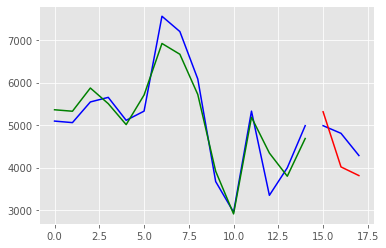

In [126]:
predictions4 = model4.predict(x_test4)
predictions_train4 = model4.predict(x_train4)

print(x_train4.shape)
print(y_train4.shape)
print(x_test4.shape)
print(y_test4.shape)
print(NN_PB_sku28.shape)

x2_4 = numpy.arange(0, 15, 1)
x3_4 = numpy.arange(15, 18, 1)

plt.plot(x2_4, y_train4, color='blue')
plt.plot(x2_4, predictions_train4, color='green')
plt.plot(x3_4, y_test4, color='blue')
plt.plot(x3_4, predictions4, color='red')

# redline - прогноз, greenline - подгонка

In [127]:
print(predictions4)

[[5313.5767]
 [4016.0544]
 [3812.336 ]]


In [118]:
# -SKU#30-

In [151]:
PB_sku30 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #30')]
PB_sku30.drop('sku_id', axis=1, inplace=True)
#PB_sku30.iloc[:,1].plot()

NN_PB_sku30 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku30['t-' + str(i)] = PB_sku30.iloc[:,1].shift(i)
    
NN_PB_sku30['t'] = PB_sku30.iloc[:,1].values
#print(NN_PB_sku30.head(13))

new_NN_PB_sku30 = NN_PB_sku30[12:]
#new_NN_PB_sku30.head()

y5 = new_NN_PB_sku30['t']
x5 = new_NN_PB_sku30.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train5 = x5[:15]
y_train5 = y5[:15]
x_test5 = x5[15:]
y_test5 = y5[15:]

#print(new_NN_PB_sku30.shape)
#print(x_train5.shape)
#print(y_train5.shape)
#print(x_test5.shape)
#print(y_test5.shape)
#print(x_train5.head(5))

x_train5 = x_train5.values
y_train5 = y_train5.values
x_test5 = x_test5.values
y_test5 = y_test5.values

# NN

model5 = Sequential()
model5.add(Dense(6, input_dim=12, activation='relu'))
model5.add(Dense(1, activation='linear'))
model5.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model5.fit(x_train5, y_train5, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 3s 194ms/step - loss: 10349238.0000 - mean_absolute_percentage_error: 39.4146
Epoch 2/300
15/15 [==============================] - 0s 133us/step - loss: 9880316.0000 - mean_absolute_percentage_error: 38.4559
Epoch 3/300
15/15 [==============================] - 0s 265us/step - loss: 9448367.0000 - mean_absolute_percentage_error: 37.5106
Epoch 4/300
15/15 [==============================] - 0s 266us/step - loss: 9077838.0000 - mean_absolute_percentage_error: 36.7423
Epoch 5/300
15/15 [==============================] - 0s 199us/step - loss: 8753947.0000 - mean_absolute_percentage_error: 36.0849
Epoch 6/300
15/15 [==============================] - 0s 266us/step - loss: 8487390.0000 - mean_absolute_percentage_error: 35.4996
Epoch 7/300
15/15 [==============================] - 0s 135us/step - loss: 8219352.0000 - mean_absolute_percentage_error: 34.8868
Epoch 8/300
15/15 [==============================] - 0s 199us/step - loss: 7969729.0000 -

Epoch 64/300
15/15 [==============================] - 0s 332us/step - loss: 4711122.0000 - mean_absolute_percentage_error: 27.0286
Epoch 65/300
15/15 [==============================] - 0s 1ms/step - loss: 4682414.0000 - mean_absolute_percentage_error: 26.9798
Epoch 66/300
15/15 [==============================] - 0s 266us/step - loss: 4653850.5000 - mean_absolute_percentage_error: 26.9328
Epoch 67/300
15/15 [==============================] - 0s 199us/step - loss: 4625445.5000 - mean_absolute_percentage_error: 26.8873
Epoch 68/300
15/15 [==============================] - 0s 399us/step - loss: 4597222.0000 - mean_absolute_percentage_error: 26.8427
Epoch 69/300
15/15 [==============================] - 0s 266us/step - loss: 4569186.0000 - mean_absolute_percentage_error: 26.7987
Epoch 70/300
15/15 [==============================] - 0s 133us/step - loss: 4541350.5000 - mean_absolute_percentage_error: 26.7548
Epoch 71/300
15/15 [==============================] - 0s 199us/step - loss: 4513723.0

Epoch 127/300
15/15 [==============================] - 0s 134us/step - loss: 3225784.5000 - mean_absolute_percentage_error: 23.2901
Epoch 128/300
15/15 [==============================] - 0s 199us/step - loss: 3206875.5000 - mean_absolute_percentage_error: 23.2312
Epoch 129/300
15/15 [==============================] - 0s 199us/step - loss: 3188094.5000 - mean_absolute_percentage_error: 23.1722
Epoch 130/300
15/15 [==============================] - 0s 333us/step - loss: 3169440.0000 - mean_absolute_percentage_error: 23.1132
Epoch 131/300
15/15 [==============================] - 0s 266us/step - loss: 3150907.2500 - mean_absolute_percentage_error: 23.0542
Epoch 132/300
15/15 [==============================] - 0s 199us/step - loss: 3132499.5000 - mean_absolute_percentage_error: 22.9951
Epoch 133/300
15/15 [==============================] - 0s 265us/step - loss: 3114213.7500 - mean_absolute_percentage_error: 22.9361
Epoch 134/300
15/15 [==============================] - 0s 199us/step - loss:

Epoch 190/300
15/15 [==============================] - 0s 332us/step - loss: 2245722.5000 - mean_absolute_percentage_error: 19.7351
Epoch 191/300
15/15 [==============================] - 0s 200us/step - loss: 2233081.0000 - mean_absolute_percentage_error: 19.6817
Epoch 192/300
15/15 [==============================] - 0s 266us/step - loss: 2220514.5000 - mean_absolute_percentage_error: 19.6283
Epoch 193/300
15/15 [==============================] - 0s 266us/step - loss: 2208024.5000 - mean_absolute_percentage_error: 19.5751
Epoch 194/300
15/15 [==============================] - 0s 266us/step - loss: 2195608.0000 - mean_absolute_percentage_error: 19.5219
Epoch 195/300
15/15 [==============================] - 0s 199us/step - loss: 2183265.2500 - mean_absolute_percentage_error: 19.4688
Epoch 196/300
15/15 [==============================] - 0s 199us/step - loss: 2170996.2500 - mean_absolute_percentage_error: 19.4158
Epoch 197/300
15/15 [==============================] - 0s 331us/step - loss:

Epoch 253/300
15/15 [==============================] - 0s 465us/step - loss: 1576801.3750 - mean_absolute_percentage_error: 16.5684
Epoch 254/300
15/15 [==============================] - 0s 199us/step - loss: 1567982.1250 - mean_absolute_percentage_error: 16.5272
Epoch 255/300
15/15 [==============================] - 0s 266us/step - loss: 1559211.1250 - mean_absolute_percentage_error: 16.4862
Epoch 256/300
15/15 [==============================] - 0s 532us/step - loss: 1550489.8750 - mean_absolute_percentage_error: 16.4452
Epoch 257/300
15/15 [==============================] - 0s 334us/step - loss: 1541815.2500 - mean_absolute_percentage_error: 16.4042
Epoch 258/300
15/15 [==============================] - 0s 332us/step - loss: 1533188.5000 - mean_absolute_percentage_error: 16.3633
Epoch 259/300
15/15 [==============================] - 0s 332us/step - loss: 1524608.8750 - mean_absolute_percentage_error: 16.3225
Epoch 260/300
15/15 [==============================] - 0s 265us/step - loss:

In [130]:
scores5 = model5.evaluate(x_test5, y_test5)
y_pred5 = model5.predict(x_test5)

def smape(y_test5, y_pred5):
    return 100/len(y_test5) * np.sum(2 * np.abs(y_pred5 - y_test5) / (np.abs(y_test5) + np.abs(y_pred5)))

print(smape(y_test5, y_pred5))
# Подсчитали SMAPE

3/3 [==============================] - 1s 359ms/step
79.72889007458875


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


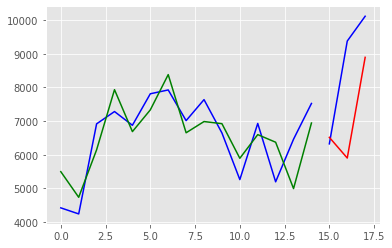

In [131]:
predictions5 = model5.predict(x_test5)
predictions_train5 = model5.predict(x_train5)

print(x_train5.shape)
print(y_train5.shape)
print(x_test5.shape)
print(y_test5.shape)
print(NN_PB_sku30.shape)

x2_5 = numpy.arange(0, 15, 1)
x3_5 = numpy.arange(15, 18, 1)

plt.plot(x2_5, y_train5, color='blue')
plt.plot(x2_5, predictions_train5, color='green')
plt.plot(x3_5, y_test5, color='blue')
plt.plot(x3_5, predictions5, color='red')

# redline - прогноз, greenline - подгонка

In [132]:
print(predictions5)

[[6516.871 ]
 [5902.7275]
 [8894.543 ]]


In [459]:
# -SKU#31-

In [176]:
PB_sku31 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #31')]
PB_sku31.drop('sku_id', axis=1, inplace=True)
#PB_sku31.iloc[:,1].plot()

NN_PB_sku31 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku31['t-' + str(i)] = PB_sku31.iloc[:,1].shift(i)
    
NN_PB_sku31['t'] = PB_sku31.iloc[:,1].values
#print(NN_PB_sku31.head(13))

new_NN_PB_sku31 = NN_PB_sku31[12:]
#new_NN_PB_sku31.head()

y6 = new_NN_PB_sku31['t']
x6 = new_NN_PB_sku31.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train6 = x6[:14]
y_train6 = y6[:14]
x_test6 = x6[14:]
y_test6 = y6[14:]

#print(new_NN_PB_sku31.shape)
#print(x_train6.shape)
#print(y_train6.shape)
#print(x_test6.shape)
#print(y_test6.shape)
#print(x_train6.head(5))

x_train6 = x_train6.values
y_train6 = y_train6.values
x_test6 = x_test6.values
y_test6 = y_test6.values

# NN

model6 = Sequential()
model6.add(Dense(6, input_dim=12, activation='relu'))
model6.add(Dense(1, activation='linear'))
model6.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model6.fit(x_train6, y_train6, epochs=300, batch_size=None)

Epoch 1/300
14/14 [==============================] - 3s 245ms/step - loss: 286810.0938 - mean_absolute_percentage_error: 40.9538
Epoch 2/300
14/14 [==============================] - 0s 287us/step - loss: 262680.9688 - mean_absolute_percentage_error: 39.0316
Epoch 3/300
14/14 [==============================] - 0s 1ms/step - loss: 240213.9844 - mean_absolute_percentage_error: 37.1419
Epoch 4/300
14/14 [==============================] - 0s 427us/step - loss: 219429.9219 - mean_absolute_percentage_error: 35.2861
Epoch 5/300
14/14 [==============================] - 0s 213us/step - loss: 200807.1250 - mean_absolute_percentage_error: 33.4968
Epoch 6/300
14/14 [==============================] - 0s 1ms/step - loss: 184462.1094 - mean_absolute_percentage_error: 31.7977
Epoch 7/300
14/14 [==============================] - 0s 281us/step - loss: 170160.8594 - mean_absolute_percentage_error: 30.2018
Epoch 8/300
14/14 [==============================] - 0s 499us/step - loss: 158319.6719 - mean_absolut

Epoch 65/300
14/14 [==============================] - 0s 570us/step - loss: 69003.0469 - mean_absolute_percentage_error: 17.9151
Epoch 66/300
14/14 [==============================] - 0s 501us/step - loss: 68909.8672 - mean_absolute_percentage_error: 17.9147
Epoch 67/300
14/14 [==============================] - 0s 283us/step - loss: 68809.0078 - mean_absolute_percentage_error: 17.9123
Epoch 68/300
14/14 [==============================] - 0s 287us/step - loss: 68700.1953 - mean_absolute_percentage_error: 17.9078
Epoch 69/300
14/14 [==============================] - 0s 428us/step - loss: 68583.3359 - mean_absolute_percentage_error: 17.9015
Epoch 70/300
14/14 [==============================] - 0s 212us/step - loss: 68458.4609 - mean_absolute_percentage_error: 17.8932
Epoch 71/300
14/14 [==============================] - 0s 213us/step - loss: 68325.8828 - mean_absolute_percentage_error: 17.8833
Epoch 72/300
14/14 [==============================] - 0s 356us/step - loss: 68185.9141 - mean_abs

Epoch 129/300
14/14 [==============================] - 0s 285us/step - loss: 61410.7617 - mean_absolute_percentage_error: 16.9437
Epoch 130/300
14/14 [==============================] - 0s 214us/step - loss: 61294.7891 - mean_absolute_percentage_error: 16.9261
Epoch 131/300
14/14 [==============================] - 0s 570us/step - loss: 61168.0977 - mean_absolute_percentage_error: 16.9076
Epoch 132/300
14/14 [==============================] - 0s 285us/step - loss: 61068.6992 - mean_absolute_percentage_error: 16.8922
Epoch 133/300
14/14 [==============================] - 0s 570us/step - loss: 60964.5586 - mean_absolute_percentage_error: 16.8760
Epoch 134/300
14/14 [==============================] - 0s 285us/step - loss: 60856.0898 - mean_absolute_percentage_error: 16.8591
Epoch 135/300
14/14 [==============================] - 0s 286us/step - loss: 60743.8789 - mean_absolute_percentage_error: 16.8415
Epoch 136/300
14/14 [==============================] - 0s 356us/step - loss: 60652.3086 - 

Epoch 193/300
14/14 [==============================] - 0s 285us/step - loss: 56123.2695 - mean_absolute_percentage_error: 16.1058
Epoch 194/300
14/14 [==============================] - 0s 285us/step - loss: 56074.5664 - mean_absolute_percentage_error: 16.0990
Epoch 195/300
14/14 [==============================] - 0s 356us/step - loss: 56019.5234 - mean_absolute_percentage_error: 16.0896
Epoch 196/300
14/14 [==============================] - 0s 214us/step - loss: 55958.7539 - mean_absolute_percentage_error: 16.0778
Epoch 197/300
14/14 [==============================] - 0s 427us/step - loss: 55892.9961 - mean_absolute_percentage_error: 16.0638
Epoch 198/300
14/14 [==============================] - 0s 499us/step - loss: 55868.2891 - mean_absolute_percentage_error: 16.0535
Epoch 199/300
14/14 [==============================] - 0s 213us/step - loss: 55812.0117 - mean_absolute_percentage_error: 16.0435
Epoch 200/300
14/14 [==============================] - 0s 283us/step - loss: 55725.4727 - 

Epoch 257/300
14/14 [==============================] - 0s 216us/step - loss: 52536.5820 - mean_absolute_percentage_error: 15.4665
Epoch 258/300
14/14 [==============================] - 0s 285us/step - loss: 52486.3555 - mean_absolute_percentage_error: 15.4591
Epoch 259/300
14/14 [==============================] - 0s 356us/step - loss: 52431.2930 - mean_absolute_percentage_error: 15.4491
Epoch 260/300
14/14 [==============================] - 0s 356us/step - loss: 52371.9102 - mean_absolute_percentage_error: 15.4368
Epoch 261/300
14/14 [==============================] - 0s 499us/step - loss: 52308.8047 - mean_absolute_percentage_error: 15.4224
Epoch 262/300
14/14 [==============================] - 0s 212us/step - loss: 52246.0898 - mean_absolute_percentage_error: 15.4100
Epoch 263/300
14/14 [==============================] - 0s 284us/step - loss: 52184.1797 - mean_absolute_percentage_error: 15.3985
Epoch 264/300
14/14 [==============================] - 0s 283us/step - loss: 52122.4258 - 

In [166]:
scores6 = model6.evaluate(x_test6, y_test6)
y_pred6 = model6.predict(x_test6)

def smape(y_test6, y_pred6):
    return 100/len(y_test6) * np.sum(2 * np.abs(y_pred6 - y_test6) / (np.abs(y_test6) + np.abs(y_pred6)))

print(smape(y_test6, y_pred6))
# Подсчитали SMAPE

3/3 [==============================] - 1s 495ms/step
229.63893451687926


(14, 12)
(14,)
(3, 12)
(3,)
(29, 13)


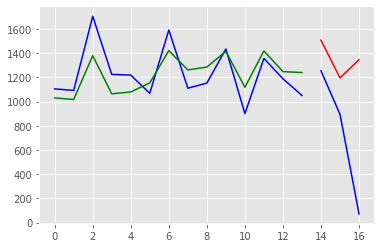

In [167]:
predictions6 = model6.predict(x_test6)
predictions_train6 = model6.predict(x_train6)

print(x_train6.shape)
print(y_train6.shape)
print(x_test6.shape)
print(y_test6.shape)
print(NN_PB_sku31.shape)

x2_6 = numpy.arange(0, 14, 1)
x3_6 = numpy.arange(14, 17, 1)

plt.plot(x2_6, y_train6, color='blue')
plt.plot(x2_6, predictions_train6, color='green')
plt.plot(x3_6, y_test6, color='blue')
plt.plot(x3_6, predictions6, color='red')

# redline - прогноз, greenline - подгонка

In [168]:
print(predictions6)

[[1506.276 ]
 [1194.9891]
 [1344.9976]]


In [ ]:
# -SKU#33-

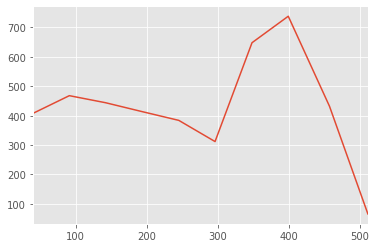

In [489]:
PB_sku33 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #33')]
PB_sku33.drop('sku_id', axis=1, inplace=True)
PB_sku33.iloc[:,1].plot()
# ВЫШЕЛ ИЗ ПРОДАЖ В 2019

In [490]:
# -SKU#38-

In [202]:
PB_sku38 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #38')]
PB_sku38.drop('sku_id', axis=1, inplace=True)
#PB_sku38.iloc[:,1].plot()

NN_PB_sku38 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku38['t-' + str(i)] = PB_sku38.iloc[:,1].shift(i)
    
NN_PB_sku38['t'] = PB_sku38.iloc[:,1].values
#print(NN_PB_sku38.head(13))

new_NN_PB_sku38 = NN_PB_sku38[12:]
#new_NN_PB_sku38.head()

y7 = new_NN_PB_sku38['t']
x7 = new_NN_PB_sku38.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train7 = x7[:15]
y_train7 = y7[:15]
x_test7 = x7[15:]
y_test7 = y7[15:]

#print(new_NN_PB_sku38.shape)
#print(x_train7.shape)
#print(y_train7.shape)
#print(x_test7.shape)
#print(y_test7.shape)
#print(x_train7.head(5))

x_train7 = x_train7.values
y_train7 = y_train7.values
x_test7 = x_test7.values
y_test7 = y_test7.values

# NN

model7 = Sequential()
model7.add(Dense(6, input_dim=12, activation='relu'))
model7.add(Dense(1, activation='linear'))
model7.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model7.fit(x_train7, y_train7, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 4s 268ms/step - loss: 790140.5625 - mean_absolute_percentage_error: 53.4216
Epoch 2/300
15/15 [==============================] - 0s 266us/step - loss: 733537.8750 - mean_absolute_percentage_error: 50.9710
Epoch 3/300
15/15 [==============================] - 0s 798us/step - loss: 678668.0000 - mean_absolute_percentage_error: 48.4994
Epoch 4/300
15/15 [==============================] - 0s 399us/step - loss: 624982.8750 - mean_absolute_percentage_error: 46.0051
Epoch 5/300
15/15 [==============================] - 0s 332us/step - loss: 574108.9375 - mean_absolute_percentage_error: 43.5186
Epoch 6/300
15/15 [==============================] - 0s 465us/step - loss: 525954.3125 - mean_absolute_percentage_error: 41.0260
Epoch 7/300
15/15 [==============================] - 0s 199us/step - loss: 480553.7188 - mean_absolute_percentage_error: 38.5229
Epoch 8/300
15/15 [==============================] - 0s 399us/step - loss: 438194.5000 - mean_abs

Epoch 65/300
15/15 [==============================] - 0s 266us/step - loss: 104397.8984 - mean_absolute_percentage_error: 14.3159
Epoch 66/300
15/15 [==============================] - 0s 332us/step - loss: 104165.7734 - mean_absolute_percentage_error: 14.3298
Epoch 67/300
15/15 [==============================] - 0s 399us/step - loss: 103915.0781 - mean_absolute_percentage_error: 14.3509
Epoch 68/300
15/15 [==============================] - 0s 399us/step - loss: 103651.9844 - mean_absolute_percentage_error: 14.3781
Epoch 69/300
15/15 [==============================] - 0s 931us/step - loss: 103382.7656 - mean_absolute_percentage_error: 14.4104
Epoch 70/300
15/15 [==============================] - 0s 598us/step - loss: 103113.1797 - mean_absolute_percentage_error: 14.4466
Epoch 71/300
15/15 [==============================] - 0s 332us/step - loss: 102848.0938 - mean_absolute_percentage_error: 14.4855
Epoch 72/300
15/15 [==============================] - 0s 399us/step - loss: 102591.4688 - 

Epoch 129/300
15/15 [==============================] - 0s 199us/step - loss: 92191.4297 - mean_absolute_percentage_error: 14.3466
Epoch 130/300
15/15 [==============================] - 0s 266us/step - loss: 92013.2969 - mean_absolute_percentage_error: 14.3375
Epoch 131/300
15/15 [==============================] - 0s 266us/step - loss: 91835.2500 - mean_absolute_percentage_error: 14.3278
Epoch 132/300
15/15 [==============================] - 0s 399us/step - loss: 91657.2422 - mean_absolute_percentage_error: 14.3176
Epoch 133/300
15/15 [==============================] - 0s 465us/step - loss: 91478.6797 - mean_absolute_percentage_error: 14.3070
Epoch 134/300
15/15 [==============================] - 0s 332us/step - loss: 91300.8672 - mean_absolute_percentage_error: 14.2960
Epoch 135/300
15/15 [==============================] - 0s 266us/step - loss: 91123.2031 - mean_absolute_percentage_error: 14.2848
Epoch 136/300
15/15 [==============================] - 0s 1ms/step - loss: 90945.5859 - me

Epoch 193/300
15/15 [==============================] - 0s 266us/step - loss: 81137.4531 - mean_absolute_percentage_error: 13.6680
Epoch 194/300
15/15 [==============================] - 0s 997us/step - loss: 80972.3359 - mean_absolute_percentage_error: 13.6600
Epoch 195/300
15/15 [==============================] - 0s 266us/step - loss: 80807.0469 - mean_absolute_percentage_error: 13.6519
Epoch 196/300
15/15 [==============================] - 0s 466us/step - loss: 80642.4297 - mean_absolute_percentage_error: 13.6439
Epoch 197/300
15/15 [==============================] - 0s 1ms/step - loss: 80478.0703 - mean_absolute_percentage_error: 13.6359
Epoch 198/300
15/15 [==============================] - 0s 1ms/step - loss: 80314.0781 - mean_absolute_percentage_error: 13.6278
Epoch 199/300
15/15 [==============================] - 0s 332us/step - loss: 80149.9766 - mean_absolute_percentage_error: 13.6197
Epoch 200/300
15/15 [==============================] - 0s 199us/step - loss: 79986.4453 - mean

15/15 [==============================] - 0s 532us/step - loss: 71350.0703 - mean_absolute_percentage_error: 13.1342
Epoch 257/300
15/15 [==============================] - 0s 199us/step - loss: 71206.1250 - mean_absolute_percentage_error: 13.1255
Epoch 258/300
15/15 [==============================] - 0s 332us/step - loss: 71062.8984 - mean_absolute_percentage_error: 13.1168
Epoch 259/300
15/15 [==============================] - 0s 266us/step - loss: 70920.1406 - mean_absolute_percentage_error: 13.1080
Epoch 260/300
15/15 [==============================] - 0s 332us/step - loss: 70777.6562 - mean_absolute_percentage_error: 13.0993
Epoch 261/300
15/15 [==============================] - 0s 532us/step - loss: 70635.3906 - mean_absolute_percentage_error: 13.0906
Epoch 262/300
15/15 [==============================] - 0s 399us/step - loss: 70493.7891 - mean_absolute_percentage_error: 13.0818
Epoch 263/300
15/15 [==============================] - 0s 332us/step - loss: 70352.3438 - mean_absolute_

In [203]:
scores7 = model7.evaluate(x_test7, y_test7)
y_pred7 = model7.predict(x_test7)

def smape(y_test7, y_pred7):
    return 100/len(y_test7) * np.sum(2 * np.abs(y_pred7 - y_test7) / (np.abs(y_test7) + np.abs(y_pred7)))

print(smape(y_test7, y_pred7))
# Подсчитали SMAPE

3/3 [==============================] - 2s 564ms/step
165.36258908067109


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


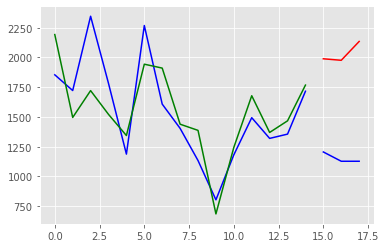

In [204]:
predictions7 = model7.predict(x_test7)
predictions_train7 = model7.predict(x_train7)

print(x_train7.shape)
print(y_train7.shape)
print(x_test7.shape)
print(y_test7.shape)
print(NN_PB_sku38.shape)

x2_7 = numpy.arange(0, 15, 1)
x3_7 = numpy.arange(15, 18, 1)

plt.plot(x2_7, y_train7, color='blue')
plt.plot(x2_7, predictions_train7, color='green')
plt.plot(x3_7, y_test7, color='blue')
plt.plot(x3_7, predictions7, color='red')

# redline - прогноз, greenline - подгонка

In [205]:
print(predictions7)

[[1988.6443]
 [1976.0043]
 [2134.2166]]


In [ ]:
# -SKU#41-

In [241]:
PB_sku41 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #41')]
PB_sku41.drop('sku_id', axis=1, inplace=True)
#PB_sku41.iloc[:,1].plot()

NN_PB_sku41 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku41['t-' + str(i)] = PB_sku41.iloc[:,1].shift(i)
    
NN_PB_sku41['t'] = PB_sku41.iloc[:,1].values
#print(NN_PB_sku41.head(13))

new_NN_PB_sku41 = NN_PB_sku41[12:]
#new_NN_PB_sku41.head()

y8 = new_NN_PB_sku41['t']
x8 = new_NN_PB_sku41.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train8 = x8[:14]
y_train8 = y8[:14]
x_test8 = x8[14:]
y_test8 = y8[14:]

#print(new_NN_PB_sku41.shape)
#print(x_train8.shape)
#print(y_train8.shape)
#print(x_test8.shape)
#print(y_test8.shape)
#print(x_train8.head(5))

x_train8 = x_train8.values
y_train8 = y_train8.values
x_test8 = x_test8.values
y_test8 = y_test8.values

# NN

model8 = Sequential()
model8.add(Dense(6, input_dim=12, activation='relu'))
model8.add(Dense(1, activation='linear'))
model8.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model8.fit(x_train8, y_train8, epochs=300, batch_size=None)

Epoch 1/300
14/14 [==============================] - 5s 362ms/step - loss: 6850031.0000 - mean_absolute_percentage_error: 176.5043
Epoch 2/300
14/14 [==============================] - 0s 283us/step - loss: 6736071.5000 - mean_absolute_percentage_error: 174.9951
Epoch 3/300
14/14 [==============================] - 0s 498us/step - loss: 6608128.0000 - mean_absolute_percentage_error: 173.3103
Epoch 4/300
14/14 [==============================] - 0s 499us/step - loss: 6479909.0000 - mean_absolute_percentage_error: 171.6248
Epoch 5/300
14/14 [==============================] - 0s 498us/step - loss: 6357704.0000 - mean_absolute_percentage_error: 169.9869
Epoch 6/300
14/14 [==============================] - 0s 356us/step - loss: 6242468.0000 - mean_absolute_percentage_error: 168.4223
Epoch 7/300
14/14 [==============================] - 0s 714us/step - loss: 6132569.0000 - mean_absolute_percentage_error: 166.8968
Epoch 8/300
14/14 [==============================] - 0s 283us/step - loss: 6027108.

Epoch 64/300
14/14 [==============================] - 0s 355us/step - loss: 3088254.5000 - mean_absolute_percentage_error: 115.9650
Epoch 65/300
14/14 [==============================] - 0s 356us/step - loss: 3066471.7500 - mean_absolute_percentage_error: 115.5219
Epoch 66/300
14/14 [==============================] - 0s 283us/step - loss: 3045328.7500 - mean_absolute_percentage_error: 115.0903
Epoch 67/300
14/14 [==============================] - 0s 427us/step - loss: 3025017.7500 - mean_absolute_percentage_error: 114.6725
Epoch 68/300
14/14 [==============================] - 0s 354us/step - loss: 3005618.0000 - mean_absolute_percentage_error: 114.2709
Epoch 69/300
14/14 [==============================] - 0s 427us/step - loss: 2986424.5000 - mean_absolute_percentage_error: 113.8719
Epoch 70/300
14/14 [==============================] - 0s 499us/step - loss: 2967684.0000 - mean_absolute_percentage_error: 113.4807
Epoch 71/300
14/14 [==============================] - 0s 427us/step - loss: 

Epoch 126/300
14/14 [==============================] - 0s 356us/step - loss: 2450914.5000 - mean_absolute_percentage_error: 102.3821
Epoch 127/300
14/14 [==============================] - 0s 499us/step - loss: 2447172.5000 - mean_absolute_percentage_error: 102.3012
Epoch 128/300
14/14 [==============================] - 0s 427us/step - loss: 2443461.7500 - mean_absolute_percentage_error: 102.2209
Epoch 129/300
14/14 [==============================] - 0s 427us/step - loss: 2439780.0000 - mean_absolute_percentage_error: 102.1411
Epoch 130/300
14/14 [==============================] - 0s 284us/step - loss: 2436124.7500 - mean_absolute_percentage_error: 102.0617
Epoch 131/300
14/14 [==============================] - 0s 499us/step - loss: 2432494.2500 - mean_absolute_percentage_error: 101.9828
Epoch 132/300
14/14 [==============================] - 0s 285us/step - loss: 2428886.2500 - mean_absolute_percentage_error: 101.9042
Epoch 133/300
14/14 [==============================] - 0s 499us/step 

Epoch 188/300
14/14 [==============================] - 0s 284us/step - loss: 2360706.7500 - mean_absolute_percentage_error: 100.6870
Epoch 189/300
14/14 [==============================] - 0s 427us/step - loss: 2360091.2500 - mean_absolute_percentage_error: 100.6754
Epoch 190/300
14/14 [==============================] - 0s 499us/step - loss: 2359476.5000 - mean_absolute_percentage_error: 100.6637
Epoch 191/300
14/14 [==============================] - 0s 285us/step - loss: 2358862.5000 - mean_absolute_percentage_error: 100.6521
Epoch 192/300
14/14 [==============================] - 0s 427us/step - loss: 2358249.2500 - mean_absolute_percentage_error: 100.6405
Epoch 193/300
14/14 [==============================] - 0s 427us/step - loss: 2357636.2500 - mean_absolute_percentage_error: 100.6288
Epoch 194/300
14/14 [==============================] - 0s 427us/step - loss: 2357023.7500 - mean_absolute_percentage_error: 100.6172
Epoch 195/300
14/14 [==============================] - 0s 214us/step 

Epoch 250/300
14/14 [==============================] - 0s 499us/step - loss: 2334825.2500 - mean_absolute_percentage_error: 100.1927
Epoch 251/300
14/14 [==============================] - 0s 427us/step - loss: 2334718.5000 - mean_absolute_percentage_error: 100.1907
Epoch 252/300
14/14 [==============================] - 0s 356us/step - loss: 2334613.7500 - mean_absolute_percentage_error: 100.1886
Epoch 253/300
14/14 [==============================] - 0s 499us/step - loss: 2334510.0000 - mean_absolute_percentage_error: 100.1866
Epoch 254/300
14/14 [==============================] - 0s 427us/step - loss: 2334406.7500 - mean_absolute_percentage_error: 100.1847
Epoch 255/300
14/14 [==============================] - 0s 355us/step - loss: 2334304.7500 - mean_absolute_percentage_error: 100.1827
Epoch 256/300
14/14 [==============================] - 0s 567us/step - loss: 2334203.5000 - mean_absolute_percentage_error: 100.1807
Epoch 257/300
14/14 [==============================] - 0s 427us/step 

In [232]:
scores8 = model8.evaluate(x_test8, y_test8)
y_pred8 = model8.predict(x_test8)

def smape(y_test8, y_pred8):
    return 100/len(y_test8) * np.sum(2 * np.abs(y_pred8 - y_test8) / (np.abs(y_test8) + np.abs(y_pred8)))

print(smape(y_test8, y_pred8))
# Подсчитали SMAPE

3/3 [==============================] - 2s 652ms/step
94.82514141080468


(14, 12)
(14,)
(3, 12)
(3,)
(29, 13)


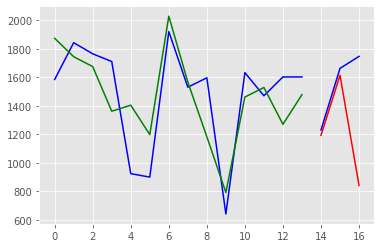

In [233]:
predictions8 = model8.predict(x_test8)
predictions_train8 = model8.predict(x_train8)

print(x_train8.shape)
print(y_train8.shape)
print(x_test8.shape)
print(y_test8.shape)
print(NN_PB_sku41.shape)

x2_8 = numpy.arange(0, 14, 1)
x3_8 = numpy.arange(14, 17, 1)

plt.plot(x2_8, y_train8, color='blue')
plt.plot(x2_8, predictions_train8, color='green')
plt.plot(x3_8, y_test8, color='blue')
plt.plot(x3_8, predictions8, color='red')

# redline - прогноз, greenline - подгонка

In [234]:
print(predictions8)

[[1192.9733]
 [1613.4377]
 [ 841.0977]]


In [518]:
# -SKU#42-

In [266]:
PB_sku42 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #42')]
PB_sku42.drop('sku_id', axis=1, inplace=True)
#PB_sku42.iloc[:,1].plot()

NN_PB_sku42 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku42['t-' + str(i)] = PB_sku42.iloc[:,1].shift(i)
    
NN_PB_sku42['t'] = PB_sku42.iloc[:,1].values
#print(NN_PB_sku42.head(13))

new_NN_PB_sku42 = NN_PB_sku42[12:]
#new_NN_PB_sku42.head()

y9 = new_NN_PB_sku42['t']
x9 = new_NN_PB_sku42.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train9 = x9[:15]
y_train9 = y9[:15]
x_test9 = x9[15:]
y_test9 = y9[15:]

#print(new_NN_PB_sku42.shape)
#print(x_train9.shape)
#print(y_train9.shape)
#print(x_test9.shape)
#print(y_test9.shape)
#print(x_train9.head(5))

x_train9 = x_train9.values
y_train9 = y_train9.values
x_test9 = x_test9.values
y_test9 = y_test9.values

# NN

model9 = Sequential()
model9.add(Dense(6, input_dim=12, activation='relu'))
model9.add(Dense(1, activation='linear'))
model9.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model9.fit(x_train9, y_train9, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 6s 399ms/step - loss: 4881.7012 - mean_absolute_percentage_error: 24.8652
Epoch 2/300
15/15 [==============================] - 0s 334us/step - loss: 4798.6484 - mean_absolute_percentage_error: 24.6205
Epoch 3/300
15/15 [==============================] - 0s 598us/step - loss: 4695.2798 - mean_absolute_percentage_error: 24.2943
Epoch 4/300
15/15 [==============================] - 0s 331us/step - loss: 4600.9438 - mean_absolute_percentage_error: 24.2419
Epoch 5/300
15/15 [==============================] - 0s 467us/step - loss: 4514.5610 - mean_absolute_percentage_error: 24.3176
Epoch 6/300
15/15 [==============================] - 0s 397us/step - loss: 4438.4160 - mean_absolute_percentage_error: 24.6626
Epoch 7/300
15/15 [==============================] - 0s 332us/step - loss: 4367.1738 - mean_absolute_percentage_error: 24.9838
Epoch 8/300
15/15 [==============================] - 0s 399us/step - loss: 4301.8813 - mean_absolute_percentage

Epoch 66/300
15/15 [==============================] - 0s 463us/step - loss: 2699.6511 - mean_absolute_percentage_error: 24.9526
Epoch 67/300
15/15 [==============================] - 0s 334us/step - loss: 2694.6160 - mean_absolute_percentage_error: 24.9407
Epoch 68/300
15/15 [==============================] - 0s 397us/step - loss: 2689.5969 - mean_absolute_percentage_error: 24.9268
Epoch 69/300
15/15 [==============================] - 0s 332us/step - loss: 2684.5945 - mean_absolute_percentage_error: 24.9108
Epoch 70/300
15/15 [==============================] - 0s 731us/step - loss: 2679.6096 - mean_absolute_percentage_error: 24.8930
Epoch 71/300
15/15 [==============================] - 0s 399us/step - loss: 2674.6084 - mean_absolute_percentage_error: 24.8736
Epoch 72/300
15/15 [==============================] - 0s 467us/step - loss: 2669.6597 - mean_absolute_percentage_error: 24.8530
Epoch 73/300
15/15 [==============================] - 0s 266us/step - loss: 2664.7302 - mean_absolute_pe

Epoch 130/300
15/15 [==============================] - 0s 268us/step - loss: 2415.0249 - mean_absolute_percentage_error: 23.9051
Epoch 131/300
15/15 [==============================] - 0s 264us/step - loss: 2411.1841 - mean_absolute_percentage_error: 23.8903
Epoch 132/300
15/15 [==============================] - 0s 532us/step - loss: 2407.3611 - mean_absolute_percentage_error: 23.8792
Epoch 133/300
15/15 [==============================] - 0s 399us/step - loss: 2403.5564 - mean_absolute_percentage_error: 23.8724
Epoch 134/300
15/15 [==============================] - 0s 398us/step - loss: 2399.7693 - mean_absolute_percentage_error: 23.8655
Epoch 135/300
15/15 [==============================] - 0s 399us/step - loss: 2396.0125 - mean_absolute_percentage_error: 23.8586
Epoch 136/300
15/15 [==============================] - 0s 532us/step - loss: 2392.2610 - mean_absolute_percentage_error: 23.8517
Epoch 137/300
15/15 [==============================] - 0s 332us/step - loss: 2388.5266 - mean_abs

Epoch 194/300
15/15 [==============================] - 0s 399us/step - loss: 2202.7710 - mean_absolute_percentage_error: 23.4068
Epoch 195/300
15/15 [==============================] - 0s 399us/step - loss: 2199.9446 - mean_absolute_percentage_error: 23.3986
Epoch 196/300
15/15 [==============================] - 0s 332us/step - loss: 2197.1252 - mean_absolute_percentage_error: 23.3904
Epoch 197/300
15/15 [==============================] - 0s 533us/step - loss: 2194.3196 - mean_absolute_percentage_error: 23.3821
Epoch 198/300
15/15 [==============================] - 0s 398us/step - loss: 2191.5330 - mean_absolute_percentage_error: 23.3738
Epoch 199/300
15/15 [==============================] - 0s 399us/step - loss: 2188.7539 - mean_absolute_percentage_error: 23.3655
Epoch 200/300
15/15 [==============================] - 0s 463us/step - loss: 2185.9875 - mean_absolute_percentage_error: 23.3571
Epoch 201/300
15/15 [==============================] - 0s 465us/step - loss: 2183.2412 - mean_abs

Epoch 258/300
15/15 [==============================] - 0s 401us/step - loss: 2046.2396 - mean_absolute_percentage_error: 22.8373
Epoch 259/300
15/15 [==============================] - 0s 332us/step - loss: 2044.1477 - mean_absolute_percentage_error: 22.8277
Epoch 260/300
15/15 [==============================] - 0s 467us/step - loss: 2042.0625 - mean_absolute_percentage_error: 22.8181
Epoch 261/300
15/15 [==============================] - 0s 530us/step - loss: 2039.9910 - mean_absolute_percentage_error: 22.8085
Epoch 262/300
15/15 [==============================] - 0s 465us/step - loss: 2037.9286 - mean_absolute_percentage_error: 22.7989
Epoch 263/300
15/15 [==============================] - 0s 796us/step - loss: 2035.8722 - mean_absolute_percentage_error: 22.7892
Epoch 264/300
15/15 [==============================] - 0s 399us/step - loss: 2033.8282 - mean_absolute_percentage_error: 22.7795
Epoch 265/300
15/15 [==============================] - 0s 268us/step - loss: 2031.7906 - mean_abs

In [256]:
scores9 = model9.evaluate(x_test9, y_test9)
y_pred9 = model9.predict(x_test9)

def smape(y_test9, y_pred9):
    return 100/len(y_test9) * np.sum(2 * np.abs(y_pred9 - y_test9) / (np.abs(y_test9) + np.abs(y_pred9)))

print(smape(y_test9, y_pred9))
# Подсчитали SMAPE

3/3 [==============================] - 2s 727ms/step
61.93316575546067


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


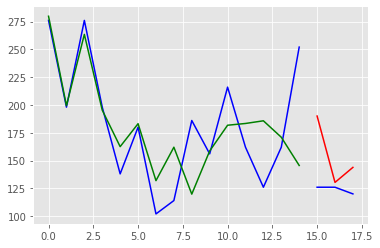

In [257]:
predictions9 = model9.predict(x_test9)
predictions_train9 = model9.predict(x_train9)

print(x_train9.shape)
print(y_train9.shape)
print(x_test9.shape)
print(y_test9.shape)
print(NN_PB_sku42.shape)

x2_9 = numpy.arange(0, 15, 1)
x3_9 = numpy.arange(15, 18, 1)

plt.plot(x2_9, y_train9, color='blue')
plt.plot(x2_9, predictions_train9, color='green')
plt.plot(x3_9, y_test9, color='blue')
plt.plot(x3_9, predictions9, color='red')

# redline - прогноз, greenline - подгонка

In [258]:
print(predictions9)

[[190.02267]
 [130.34274]
 [143.85695]]


In [525]:
# -SKU#46-

In [277]:
PB_sku46 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #46')]
PB_sku46.drop('sku_id', axis=1, inplace=True)
#PB_sku46.iloc[:,1].plot()

NN_PB_sku46 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku46['t-' + str(i)] = PB_sku46.iloc[:,1].shift(i)
    
NN_PB_sku46['t'] = PB_sku46.iloc[:,1].values
#print(NN_PB_sku46.head(13))

new_NN_PB_sku46 = NN_PB_sku46[12:]
#new_NN_PB_sku46.head()

y10 = new_NN_PB_sku46['t']
x10 = new_NN_PB_sku46.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train10 = x10[:15]
y_train10 = y10[:15]
x_test10 = x10[15:]
y_test10 = y10[15:]

#print(new_NN_PB_sku46.shape)
#print(x_train10.shape)
#print(y_train10.shape)
#print(x_test10.shape)
#print(y_test10.shape)
#print(x_train10.head(5))

x_train10 = x_train10.values
y_train10 = y_train10.values
x_test10 = x_test10.values
y_test10 = y_test10.values

# NN

model10 = Sequential()
model10.add(Dense(6, input_dim=12, activation='relu'))
model10.add(Dense(1, activation='linear'))
model10.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model10.fit(x_train10, y_train10, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 6s 412ms/step - loss: 2725923.5000 - mean_absolute_percentage_error: 38.5342
Epoch 2/300
15/15 [==============================] - 0s 266us/step - loss: 2687272.0000 - mean_absolute_percentage_error: 38.3873
Epoch 3/300
15/15 [==============================] - 0s 333us/step - loss: 2633617.0000 - mean_absolute_percentage_error: 38.2423
Epoch 4/300
15/15 [==============================] - 0s 332us/step - loss: 2590599.7500 - mean_absolute_percentage_error: 38.1659
Epoch 5/300
15/15 [==============================] - 0s 399us/step - loss: 2549570.7500 - mean_absolute_percentage_error: 38.0751
Epoch 6/300
15/15 [==============================] - 0s 332us/step - loss: 2507470.2500 - mean_absolute_percentage_error: 37.9263
Epoch 7/300
15/15 [==============================] - 0s 532us/step - loss: 2463152.2500 - mean_absolute_percentage_error: 37.6913
Epoch 8/300
15/15 [==============================] - 0s 465us/step - loss: 2417933.7500 - 

Epoch 64/300
15/15 [==============================] - 0s 932us/step - loss: 976377.1875 - mean_absolute_percentage_error: 22.0153
Epoch 65/300
15/15 [==============================] - 0s 465us/step - loss: 964477.0625 - mean_absolute_percentage_error: 21.8542
Epoch 66/300
15/15 [==============================] - 0s 333us/step - loss: 952717.7500 - mean_absolute_percentage_error: 21.6912
Epoch 67/300
15/15 [==============================] - 0s 332us/step - loss: 941101.7500 - mean_absolute_percentage_error: 21.5275
Epoch 68/300
15/15 [==============================] - 0s 332us/step - loss: 929632.2500 - mean_absolute_percentage_error: 21.3641
Epoch 69/300
15/15 [==============================] - 0s 266us/step - loss: 918310.8125 - mean_absolute_percentage_error: 21.2197
Epoch 70/300
15/15 [==============================] - 0s 532us/step - loss: 907136.8125 - mean_absolute_percentage_error: 21.0938
Epoch 71/300
15/15 [==============================] - 0s 465us/step - loss: 896107.8125 - 

Epoch 127/300
15/15 [==============================] - 0s 266us/step - loss: 498847.5312 - mean_absolute_percentage_error: 14.7683
Epoch 128/300
15/15 [==============================] - 0s 332us/step - loss: 495389.1875 - mean_absolute_percentage_error: 14.6701
Epoch 129/300
15/15 [==============================] - 0s 465us/step - loss: 491954.1250 - mean_absolute_percentage_error: 14.5823
Epoch 130/300
15/15 [==============================] - 0s 731us/step - loss: 489404.0625 - mean_absolute_percentage_error: 14.5149
Epoch 131/300
15/15 [==============================] - 0s 333us/step - loss: 486174.6250 - mean_absolute_percentage_error: 14.4377
Epoch 132/300
15/15 [==============================] - 0s 399us/step - loss: 482781.9375 - mean_absolute_percentage_error: 14.3588
Epoch 133/300
15/15 [==============================] - 0s 598us/step - loss: 479982.3438 - mean_absolute_percentage_error: 14.2981
Epoch 134/300
15/15 [==============================] - 0s 399us/step - loss: 477153

Epoch 190/300
15/15 [==============================] - 0s 465us/step - loss: 361802.0312 - mean_absolute_percentage_error: 12.0745
Epoch 191/300
15/15 [==============================] - 0s 266us/step - loss: 360200.4062 - mean_absolute_percentage_error: 12.0465
Epoch 192/300
15/15 [==============================] - 0s 532us/step - loss: 358580.0000 - mean_absolute_percentage_error: 12.0253
Epoch 193/300
15/15 [==============================] - 0s 1ms/step - loss: 356947.8438 - mean_absolute_percentage_error: 12.0093
Epoch 194/300
15/15 [==============================] - 0s 532us/step - loss: 355321.3750 - mean_absolute_percentage_error: 11.9966
Epoch 195/300
15/15 [==============================] - 0s 1ms/step - loss: 353701.5312 - mean_absolute_percentage_error: 11.9856
Epoch 196/300
15/15 [==============================] - 0s 465us/step - loss: 352168.2812 - mean_absolute_percentage_error: 11.9764
Epoch 197/300
15/15 [==============================] - 0s 399us/step - loss: 350642.625

Epoch 253/300
15/15 [==============================] - 0s 266us/step - loss: 280380.4375 - mean_absolute_percentage_error: 10.3345
Epoch 254/300
15/15 [==============================] - 0s 532us/step - loss: 279371.7812 - mean_absolute_percentage_error: 10.3124
Epoch 255/300
15/15 [==============================] - 0s 1ms/step - loss: 278299.0312 - mean_absolute_percentage_error: 10.2899
Epoch 256/300
15/15 [==============================] - 0s 399us/step - loss: 277275.2812 - mean_absolute_percentage_error: 10.2688
Epoch 257/300
15/15 [==============================] - 0s 331us/step - loss: 276282.1250 - mean_absolute_percentage_error: 10.2512
Epoch 258/300
15/15 [==============================] - 0s 330us/step - loss: 275277.2188 - mean_absolute_percentage_error: 10.2329
Epoch 259/300
15/15 [==============================] - 0s 598us/step - loss: 274252.3438 - mean_absolute_percentage_error: 10.2137
Epoch 260/300
15/15 [==============================] - 0s 399us/step - loss: 273211.6

In [278]:
scores10 = model10.evaluate(x_test10, y_test10)
y_pred10 = model10.predict(x_test10)

def smape(y_test10, y_pred10):
    return 100/len(y_test10) * np.sum(2 * np.abs(y_pred10 - y_test10) / (np.abs(y_test10) + np.abs(y_pred10)))

print(smape(y_test10, y_pred10))
# Подсчитали SMAPE

3/3 [==============================] - 2s 829ms/step
64.01101770689863


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


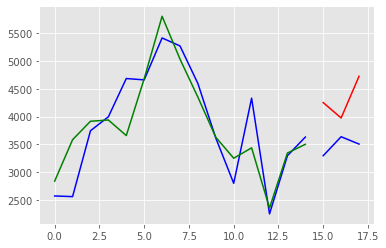

In [279]:
predictions10 = model10.predict(x_test10)
predictions_train10 = model10.predict(x_train10)

print(x_train10.shape)
print(y_train10.shape)
print(x_test10.shape)
print(y_test10.shape)
print(NN_PB_sku46.shape)

x2_10 = numpy.arange(0, 15, 1)
x3_10 = numpy.arange(15, 18, 1)

plt.plot(x2_10, y_train10, color='blue')
plt.plot(x2_10, predictions_train10, color='green')
plt.plot(x3_10, y_test10, color='blue')
plt.plot(x3_10, predictions10, color='red')

# redline - прогноз, greenline - подгонка

In [280]:
print(predictions10)

[[4251.9717]
 [3974.6487]
 [4726.738 ]]


In [283]:
# -SKU#48-

In [299]:
PB_sku48 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #48')]
PB_sku48.drop('sku_id', axis=1, inplace=True)
#PB_sku48.iloc[:,1].plot()

NN_PB_sku48 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku48['t-' + str(i)] = PB_sku48.iloc[:,1].shift(i)
    
NN_PB_sku48['t'] = PB_sku48.iloc[:,1].values
#print(NN_PB_sku48.head(13))

new_NN_PB_sku48 = NN_PB_sku48[12:]
#new_NN_PB_sku48.head()

y11 = new_NN_PB_sku48['t']
x11 = new_NN_PB_sku48.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train11 = x11[:15]
y_train11 = y11[:15]
x_test11 = x11[15:]
y_test11 = y11[15:]

#print(new_NN_PB_sku48.shape)
#print(x_train11.shape)
#print(y_train11.shape)
#print(x_test11.shape)
#print(y_test11.shape)
#print(x_train11.head(5))

x_train11 = x_train11.values
y_train11 = y_train11.values
x_test11 = x_test11.values
y_test11 = y_test11.values

# NN

model11 = Sequential()
model11.add(Dense(6, input_dim=12, activation='relu'))
model11.add(Dense(1, activation='linear'))
model11.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model11.fit(x_train11, y_train11, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 6s 430ms/step - loss: 193082000.0000 - mean_absolute_percentage_error: 240.8166
Epoch 2/300
15/15 [==============================] - 0s 332us/step - loss: 191446160.0000 - mean_absolute_percentage_error: 239.6746
Epoch 3/300
15/15 [==============================] - 0s 333us/step - loss: 189479328.0000 - mean_absolute_percentage_error: 238.2827
Epoch 4/300
15/15 [==============================] - 0s 332us/step - loss: 187314032.0000 - mean_absolute_percentage_error: 236.7751
Epoch 5/300
15/15 [==============================] - 0s 332us/step - loss: 185048272.0000 - mean_absolute_percentage_error: 235.2030
Epoch 6/300
15/15 [==============================] - 0s 466us/step - loss: 182755360.0000 - mean_absolute_percentage_error: 233.5995
Epoch 7/300
15/15 [==============================] - 0s 532us/step - loss: 180451088.0000 - mean_absolute_percentage_error: 231.9752
Epoch 8/300
15/15 [==============================] - 0s 399us/step - 

Epoch 63/300
15/15 [==============================] - 0s 332us/step - loss: 49778064.0000 - mean_absolute_percentage_error: 113.0801
Epoch 64/300
15/15 [==============================] - 0s 332us/step - loss: 48274368.0000 - mean_absolute_percentage_error: 111.0405
Epoch 65/300
15/15 [==============================] - 0s 399us/step - loss: 46810840.0000 - mean_absolute_percentage_error: 109.0205
Epoch 66/300
15/15 [==============================] - 0s 398us/step - loss: 45386820.0000 - mean_absolute_percentage_error: 107.0203
Epoch 67/300
15/15 [==============================] - 0s 332us/step - loss: 44001584.0000 - mean_absolute_percentage_error: 105.0397
Epoch 68/300
15/15 [==============================] - 0s 598us/step - loss: 42654448.0000 - mean_absolute_percentage_error: 103.0790
Epoch 69/300
15/15 [==============================] - 0s 665us/step - loss: 41344692.0000 - mean_absolute_percentage_error: 101.1381
Epoch 70/300
15/15 [==============================] - 0s 399us/step -

Epoch 125/300
15/15 [==============================] - 0s 332us/step - loss: 8428856.0000 - mean_absolute_percentage_error: 41.4354
Epoch 126/300
15/15 [==============================] - 0s 665us/step - loss: 8275607.5000 - mean_absolute_percentage_error: 41.2544
Epoch 127/300
15/15 [==============================] - 0s 332us/step - loss: 8129670.5000 - mean_absolute_percentage_error: 41.0770
Epoch 128/300
15/15 [==============================] - 0s 399us/step - loss: 7990768.0000 - mean_absolute_percentage_error: 40.9032
Epoch 129/300
15/15 [==============================] - 0s 399us/step - loss: 7858614.5000 - mean_absolute_percentage_error: 40.7330
Epoch 130/300
15/15 [==============================] - 0s 465us/step - loss: 7732935.5000 - mean_absolute_percentage_error: 40.5662
Epoch 131/300
15/15 [==============================] - 0s 399us/step - loss: 7613474.0000 - mean_absolute_percentage_error: 40.4030
Epoch 132/300
15/15 [==============================] - 0s 332us/step - loss:

Epoch 188/300
15/15 [==============================] - 0s 266us/step - loss: 5621958.5000 - mean_absolute_percentage_error: 38.2861
Epoch 189/300
15/15 [==============================] - 0s 465us/step - loss: 5617652.5000 - mean_absolute_percentage_error: 38.2889
Epoch 190/300
15/15 [==============================] - 0s 2ms/step - loss: 5613544.0000 - mean_absolute_percentage_error: 38.2913
Epoch 191/300
15/15 [==============================] - 0s 400us/step - loss: 5609602.0000 - mean_absolute_percentage_error: 38.2933
Epoch 192/300
15/15 [==============================] - 0s 399us/step - loss: 5605818.5000 - mean_absolute_percentage_error: 38.2949
Epoch 193/300
15/15 [==============================] - 0s 332us/step - loss: 5602172.5000 - mean_absolute_percentage_error: 38.2962
Epoch 194/300
15/15 [==============================] - 0s 731us/step - loss: 5598666.5000 - mean_absolute_percentage_error: 38.2971
Epoch 195/300
15/15 [==============================] - 0s 333us/step - loss: 5

Epoch 251/300
15/15 [==============================] - 0s 332us/step - loss: 5461259.0000 - mean_absolute_percentage_error: 38.0204
Epoch 252/300
15/15 [==============================] - 0s 731us/step - loss: 5458990.0000 - mean_absolute_percentage_error: 38.0127
Epoch 253/300
15/15 [==============================] - 0s 332us/step - loss: 5456717.5000 - mean_absolute_percentage_error: 38.0049
Epoch 254/300
15/15 [==============================] - 0s 266us/step - loss: 5454442.5000 - mean_absolute_percentage_error: 37.9972
Epoch 255/300
15/15 [==============================] - 0s 332us/step - loss: 5452160.5000 - mean_absolute_percentage_error: 37.9893
Epoch 256/300
15/15 [==============================] - 0s 399us/step - loss: 5449877.5000 - mean_absolute_percentage_error: 37.9815
Epoch 257/300
15/15 [==============================] - 0s 399us/step - loss: 5447584.0000 - mean_absolute_percentage_error: 37.9736
Epoch 258/300
15/15 [==============================] - 0s 266us/step - loss:

In [295]:
scores11 = model11.evaluate(x_test11, y_test11)
y_pred11 = model11.predict(x_test11)

def smape(y_test11, y_pred11):
    return 100/len(y_test11) * np.sum(2 * np.abs(y_pred11 - y_test11) / (np.abs(y_test11) + np.abs(y_pred11)))

print(smape(y_test11, y_pred11))
# Подсчитали SMAPE

3/3 [==============================] - 2s 832ms/step
71.03967248439967


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


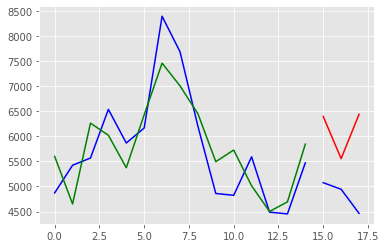

In [296]:
predictions11 = model11.predict(x_test11)
predictions_train11 = model11.predict(x_train11)

print(x_train11.shape)
print(y_train11.shape)
print(x_test11.shape)
print(y_test11.shape)
print(NN_PB_sku48.shape)

x2_11 = numpy.arange(0, 15, 1)
x3_11 = numpy.arange(15, 18, 1)

plt.plot(x2_11, y_train11, color='blue')
plt.plot(x2_11, predictions_train11, color='green')
plt.plot(x3_11, y_test11, color='blue')
plt.plot(x3_11, predictions11, color='red')

# redline - прогноз, greenline - подгонка

In [297]:
print(predictions11)

[[6399.1016]
 [5556.279 ]
 [6441.3755]]


In [ ]:
# -SKU#49-

In [326]:
PB_sku49 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #49')]
PB_sku49.drop('sku_id', axis=1, inplace=True)
#PB_sku49.iloc[:,1].plot()

NN_PB_sku49 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku49['t-' + str(i)] = PB_sku49.iloc[:,1].shift(i)
    
NN_PB_sku49['t'] = PB_sku49.iloc[:,1].values
#print(NN_AC_sku49.head(13))

new_NN_PB_sku49 = NN_PB_sku49[12:]
#new_NN_PB_sku49.head()

y12 = new_NN_PB_sku49['t']
x12 = new_NN_PB_sku49.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train12 = x12[:15]
y_train12 = y12[:15]
x_test12 = x12[15:]
y_test12 = y12[15:]

#print(new_NN_PB_sku49.shape)
#print(x_train12.shape)
#print(y_train12.shape)
#print(x_test12.shape)
#print(y_test12.shape)
#print(x_train12.head(5))

x_train12 = x_train12.values
y_train12 = y_train12.values
x_test12 = x_test12.values
y_test12 = y_test12.values

# NN

model12 = Sequential()
model12.add(Dense(6, input_dim=12, activation='relu'))
model12.add(Dense(1, activation='linear'))
model12.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model12.fit(x_train12, y_train12, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 8s 536ms/step - loss: 669487.0625 - mean_absolute_percentage_error: 56.7435
Epoch 2/300
15/15 [==============================] - 0s 399us/step - loss: 621486.3750 - mean_absolute_percentage_error: 54.0178
Epoch 3/300
15/15 [==============================] - 0s 465us/step - loss: 569907.7500 - mean_absolute_percentage_error: 50.9211
Epoch 4/300
15/15 [==============================] - 0s 332us/step - loss: 514997.7812 - mean_absolute_percentage_error: 47.6315
Epoch 5/300
15/15 [==============================] - 0s 399us/step - loss: 468569.6562 - mean_absolute_percentage_error: 44.5713
Epoch 6/300
15/15 [==============================] - 0s 731us/step - loss: 426319.5000 - mean_absolute_percentage_error: 41.4877
Epoch 7/300
15/15 [==============================] - 0s 665us/step - loss: 387600.3125 - mean_absolute_percentage_error: 38.4634
Epoch 8/300
15/15 [==============================] - 0s 731us/step - loss: 354312.8125 - mean_abs

Epoch 65/300
15/15 [==============================] - 0s 399us/step - loss: 221329.2344 - mean_absolute_percentage_error: 24.9334
Epoch 66/300
15/15 [==============================] - 0s 399us/step - loss: 220857.2969 - mean_absolute_percentage_error: 24.8849
Epoch 67/300
15/15 [==============================] - 0s 399us/step - loss: 220385.1719 - mean_absolute_percentage_error: 24.8345
Epoch 68/300
15/15 [==============================] - 0s 266us/step - loss: 219905.0625 - mean_absolute_percentage_error: 24.8006
Epoch 69/300
15/15 [==============================] - 0s 733us/step - loss: 219421.1406 - mean_absolute_percentage_error: 24.7649
Epoch 70/300
15/15 [==============================] - 0s 266us/step - loss: 218929.2344 - mean_absolute_percentage_error: 24.7204
Epoch 71/300
15/15 [==============================] - 0s 931us/step - loss: 218429.7031 - mean_absolute_percentage_error: 24.6676
Epoch 72/300
15/15 [==============================] - 0s 399us/step - loss: 217924.3906 - 

Epoch 128/300
15/15 [==============================] - 0s 396us/step - loss: 196194.4375 - mean_absolute_percentage_error: 21.9450
Epoch 129/300
15/15 [==============================] - 0s 532us/step - loss: 195889.1094 - mean_absolute_percentage_error: 21.9111
Epoch 130/300
15/15 [==============================] - 0s 332us/step - loss: 195584.6875 - mean_absolute_percentage_error: 21.8776
Epoch 131/300
15/15 [==============================] - 0s 532us/step - loss: 195282.1875 - mean_absolute_percentage_error: 21.8444
Epoch 132/300
15/15 [==============================] - 0s 665us/step - loss: 194981.5938 - mean_absolute_percentage_error: 21.8116
Epoch 133/300
15/15 [==============================] - 0s 266us/step - loss: 194683.8594 - mean_absolute_percentage_error: 21.7792
Epoch 134/300
15/15 [==============================] - 0s 665us/step - loss: 194386.9844 - mean_absolute_percentage_error: 21.7470
Epoch 135/300
15/15 [==============================] - 0s 597us/step - loss: 194092

Epoch 191/300
15/15 [==============================] - 0s 1ms/step - loss: 179766.0312 - mean_absolute_percentage_error: 20.3061
Epoch 192/300
15/15 [==============================] - 0s 532us/step - loss: 179539.7656 - mean_absolute_percentage_error: 20.2883
Epoch 193/300
15/15 [==============================] - 0s 532us/step - loss: 179314.9062 - mean_absolute_percentage_error: 20.2706
Epoch 194/300
15/15 [==============================] - 0s 532us/step - loss: 179090.3438 - mean_absolute_percentage_error: 20.2531
Epoch 195/300
15/15 [==============================] - 0s 532us/step - loss: 178867.0938 - mean_absolute_percentage_error: 20.2357
Epoch 196/300
15/15 [==============================] - 0s 531us/step - loss: 178644.7344 - mean_absolute_percentage_error: 20.2184
Epoch 197/300
15/15 [==============================] - 0s 532us/step - loss: 178423.1406 - mean_absolute_percentage_error: 20.2013
Epoch 198/300
15/15 [==============================] - 0s 532us/step - loss: 178202.3

Epoch 254/300
15/15 [==============================] - 0s 532us/step - loss: 166957.0781 - mean_absolute_percentage_error: 19.8864
Epoch 255/300
15/15 [==============================] - 0s 465us/step - loss: 166774.1875 - mean_absolute_percentage_error: 19.8823
Epoch 256/300
15/15 [==============================] - 0s 532us/step - loss: 166591.8906 - mean_absolute_percentage_error: 19.8783
Epoch 257/300
15/15 [==============================] - 0s 332us/step - loss: 166410.0781 - mean_absolute_percentage_error: 19.8743
Epoch 258/300
15/15 [==============================] - 0s 734us/step - loss: 166228.9062 - mean_absolute_percentage_error: 19.8703
Epoch 259/300
15/15 [==============================] - 0s 663us/step - loss: 166048.2188 - mean_absolute_percentage_error: 19.8663
Epoch 260/300
15/15 [==============================] - 0s 398us/step - loss: 165868.1562 - mean_absolute_percentage_error: 19.8624
Epoch 261/300
15/15 [==============================] - 0s 732us/step - loss: 165688

In [322]:
scores12 = model12.evaluate(x_test12, y_test12)
y_pred12 = model12.predict(x_test12)

def smape(y_test12, y_pred12):
    return 100/len(y_test12) * np.sum(2 * np.abs(y_pred12 - y_test12) / (np.abs(y_test12) + np.abs(y_pred12)))

print(smape(y_test12, y_pred12))
# Подсчитали SMAPE

3/3 [==============================] - 3s 976ms/step
71.98780240560174


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


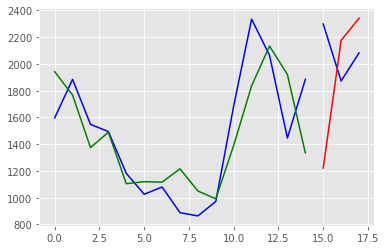

In [323]:
predictions12 = model12.predict(x_test12)
predictions_train12 = model12.predict(x_train12)

print(x_train12.shape)
print(y_train12.shape)
print(x_test12.shape)
print(y_test12.shape)
print(NN_PB_sku49.shape)

x2_12 = numpy.arange(0, 15, 1)
x3_12 = numpy.arange(15, 18, 1)

plt.plot(x2_12, y_train12, color='blue')
plt.plot(x2_12, predictions_train12, color='green')
plt.plot(x3_12, y_test12, color='blue')
plt.plot(x3_12, predictions12, color='red')

# redline - прогноз, greenline - подгонка

In [324]:
print(predictions12)

[[1221.6436]
 [2175.4998]
 [2340.8037]]


In [574]:
# -SKU#67-

In [336]:
PB_sku67 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #67')]
PB_sku67.drop('sku_id', axis=1, inplace=True)
#PB_sku67.iloc[:,1].plot()

NN_PB_sku67 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku67['t-' + str(i)] = PB_sku67.iloc[:,1].shift(i)
    
NN_PB_sku67['t'] = PB_sku67.iloc[:,1].values
#print(NN_PB_sku67.head(13))

new_NN_PB_sku67 = NN_PB_sku67[12:]
#new_NN_PB_sku67.head()

y13 = new_NN_PB_sku67['t']
x13 = new_NN_PB_sku67.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train13 = x13[:15]
y_train13 = y13[:15]
x_test13 = x13[15:]
y_test13 = y13[15:]

#print(new_NN_PB_sku67.shape)
#print(x_train13.shape)
#print(y_train13.shape)
#print(x_test13.shape)
#print(y_test13.shape)
#print(x_train13.head(5))

x_train13 = x_train13.values
y_train13 = y_train13.values
x_test13 = x_test13.values
y_test13 = y_test13.values

# NN

model13 = Sequential()
model13.add(Dense(6, input_dim=12, activation='relu'))
model13.add(Dense(1, activation='linear'))
model13.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model13.fit(x_train13, y_train13, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 8s 510ms/step - loss: 11249.3438 - mean_absolute_percentage_error: 25.7584
Epoch 2/300
15/15 [==============================] - 0s 332us/step - loss: 10479.9863 - mean_absolute_percentage_error: 24.7214
Epoch 3/300
15/15 [==============================] - 0s 598us/step - loss: 10010.5195 - mean_absolute_percentage_error: 23.8774
Epoch 4/300
15/15 [==============================] - 0s 397us/step - loss: 9682.3018 - mean_absolute_percentage_error: 23.0150
Epoch 5/300
15/15 [==============================] - 0s 663us/step - loss: 9504.9854 - mean_absolute_percentage_error: 22.1844
Epoch 6/300
15/15 [==============================] - 0s 798us/step - loss: 9452.3906 - mean_absolute_percentage_error: 21.6321
Epoch 7/300
15/15 [==============================] - 0s 399us/step - loss: 9474.8027 - mean_absolute_percentage_error: 21.1870
Epoch 8/300
15/15 [==============================] - 0s 598us/step - loss: 9518.1182 - mean_absolute_percent

Epoch 66/300
15/15 [==============================] - 0s 399us/step - loss: 6199.8828 - mean_absolute_percentage_error: 17.2089
Epoch 67/300
15/15 [==============================] - 0s 598us/step - loss: 6155.5566 - mean_absolute_percentage_error: 17.1515
Epoch 68/300
15/15 [==============================] - 0s 534us/step - loss: 6111.5405 - mean_absolute_percentage_error: 17.0891
Epoch 69/300
15/15 [==============================] - 0s 598us/step - loss: 6068.1353 - mean_absolute_percentage_error: 17.0227
Epoch 70/300
15/15 [==============================] - 0s 600us/step - loss: 6024.7803 - mean_absolute_percentage_error: 16.9521
Epoch 71/300
15/15 [==============================] - 0s 997us/step - loss: 5981.8374 - mean_absolute_percentage_error: 16.8789
Epoch 72/300
15/15 [==============================] - 0s 599us/step - loss: 5939.3530 - mean_absolute_percentage_error: 16.8045
Epoch 73/300
15/15 [==============================] - 0s 397us/step - loss: 5897.6333 - mean_absolute_pe

Epoch 130/300
15/15 [==============================] - 0s 399us/step - loss: 4079.2864 - mean_absolute_percentage_error: 13.9087
Epoch 131/300
15/15 [==============================] - 0s 665us/step - loss: 4055.4836 - mean_absolute_percentage_error: 13.8673
Epoch 132/300
15/15 [==============================] - 0s 397us/step - loss: 4031.8804 - mean_absolute_percentage_error: 13.8268
Epoch 133/300
15/15 [==============================] - 0s 1ms/step - loss: 4008.3906 - mean_absolute_percentage_error: 13.7873
Epoch 134/300
15/15 [==============================] - 0s 597us/step - loss: 3985.0942 - mean_absolute_percentage_error: 13.7488
Epoch 135/300
15/15 [==============================] - 0s 596us/step - loss: 3962.0710 - mean_absolute_percentage_error: 13.7113
Epoch 136/300
15/15 [==============================] - 0s 798us/step - loss: 3939.2485 - mean_absolute_percentage_error: 13.6745
Epoch 137/300
15/15 [==============================] - 0s 332us/step - loss: 3916.5491 - mean_absol

Epoch 194/300
15/15 [==============================] - 0s 600us/step - loss: 2913.1584 - mean_absolute_percentage_error: 11.7944
Epoch 195/300
15/15 [==============================] - 0s 532us/step - loss: 2899.6497 - mean_absolute_percentage_error: 11.7765
Epoch 196/300
15/15 [==============================] - 0s 401us/step - loss: 2886.4932 - mean_absolute_percentage_error: 11.7510
Epoch 197/300
15/15 [==============================] - 0s 399us/step - loss: 2874.2874 - mean_absolute_percentage_error: 11.7375
Epoch 198/300
15/15 [==============================] - 0s 665us/step - loss: 2861.6382 - mean_absolute_percentage_error: 11.7132
Epoch 199/300
15/15 [==============================] - 0s 399us/step - loss: 2848.5767 - mean_absolute_percentage_error: 11.6791
Epoch 200/300
15/15 [==============================] - 0s 598us/step - loss: 2835.2976 - mean_absolute_percentage_error: 11.6376
Epoch 201/300
15/15 [==============================] - 0s 466us/step - loss: 2822.9553 - mean_abs

Epoch 258/300
15/15 [==============================] - 0s 530us/step - loss: 2232.3867 - mean_absolute_percentage_error: 10.4222
Epoch 259/300
15/15 [==============================] - 0s 401us/step - loss: 2223.2739 - mean_absolute_percentage_error: 10.4018
Epoch 260/300
15/15 [==============================] - 0s 800us/step - loss: 2214.8906 - mean_absolute_percentage_error: 10.3872
Epoch 261/300
15/15 [==============================] - 0s 397us/step - loss: 2205.8640 - mean_absolute_percentage_error: 10.3595
Epoch 262/300
15/15 [==============================] - 0s 530us/step - loss: 2197.2397 - mean_absolute_percentage_error: 10.3236
Epoch 263/300
15/15 [==============================] - 0s 466us/step - loss: 2188.8584 - mean_absolute_percentage_error: 10.2963
Epoch 264/300
15/15 [==============================] - 0s 398us/step - loss: 2180.0330 - mean_absolute_percentage_error: 10.2765
Epoch 265/300
15/15 [==============================] - 0s 464us/step - loss: 2170.8513 - mean_abs

In [337]:
scores13 = model13.evaluate(x_test13, y_test13)
y_pred13 = model13.predict(x_test13)

def smape(y_test13, y_pred13):
    return 100/len(y_test13) * np.sum(2 * np.abs(y_pred13 - y_test13) / (np.abs(y_test13) + np.abs(y_pred13)))

print(smape(y_test13, y_pred13))
# Подсчитали SMAPE

3/3 [==============================] - 3s 991ms/step
63.42288257596226


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


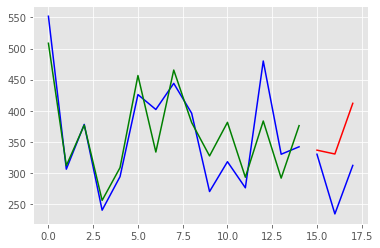

In [338]:
predictions13 = model13.predict(x_test13)
predictions_train13 = model13.predict(x_train13)

print(x_train13.shape)
print(y_train13.shape)
print(x_test13.shape)
print(y_test13.shape)
print(NN_PB_sku67.shape)

x2_13 = numpy.arange(0, 15, 1)
x3_13 = numpy.arange(15, 18, 1)

plt.plot(x2_13, y_train13, color='blue')
plt.plot(x2_13, predictions_train13, color='green')
plt.plot(x3_13, y_test13, color='blue')
plt.plot(x3_13, predictions13, color='red')

# redline - прогноз, greenline - подгонка

In [339]:
print(predictions13)

[[336.5679 ]
 [330.3958 ]
 [411.89728]]


In [343]:
# -SKU#73-

In [360]:
PB_sku73 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #73')]
PB_sku73.drop('sku_id', axis=1, inplace=True)
#PB_sku73.iloc[:,1].plot()

NN_PB_sku73 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku73['t-' + str(i)] = PB_sku73.iloc[:,1].shift(i)
    
NN_PB_sku73['t'] = PB_sku73.iloc[:,1].values
#print(NN_PB_sku73.head(13))

new_NN_PB_sku73 = NN_PB_sku73[12:]
#new_NN_PB_sku73.head()

y14 = new_NN_PB_sku73['t']
x14 = new_NN_PB_sku73.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train14 = x14[:15]
y_train14 = y14[:15]
x_test14 = x14[15:]
y_test14 = y14[15:]

#print(new_NN_PB_sku73.shape)
#print(x_train14.shape)
#print(y_train14.shape)
#print(x_test14.shape)
#print(y_test14.shape)
#print(x_train14.head(5))

x_train14 = x_train14.values
y_train14 = y_train14.values
x_test14 = x_test14.values
y_test14 = y_test14.values

# NN

model14 = Sequential()
model14.add(Dense(6, input_dim=12, activation='relu'))
model14.add(Dense(1, activation='linear'))
model14.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model14.fit(x_train14, y_train14, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 9s 575ms/step - loss: 622580.7500 - mean_absolute_percentage_error: 36.1256
Epoch 2/300
15/15 [==============================] - 0s 398us/step - loss: 554494.7500 - mean_absolute_percentage_error: 33.6317
Epoch 3/300
15/15 [==============================] - 0s 398us/step - loss: 502417.0000 - mean_absolute_percentage_error: 31.7599
Epoch 4/300
15/15 [==============================] - 0s 399us/step - loss: 453674.2812 - mean_absolute_percentage_error: 30.4179
Epoch 5/300
15/15 [==============================] - 0s 532us/step - loss: 407696.1875 - mean_absolute_percentage_error: 28.9618
Epoch 6/300
15/15 [==============================] - 0s 1ms/step - loss: 371066.9375 - mean_absolute_percentage_error: 27.5945
Epoch 7/300
15/15 [==============================] - 0s 399us/step - loss: 341100.3438 - mean_absolute_percentage_error: 26.5550
Epoch 8/300
15/15 [==============================] - 0s 732us/step - loss: 317783.0000 - mean_absol

Epoch 65/300
15/15 [==============================] - 0s 665us/step - loss: 197803.0469 - mean_absolute_percentage_error: 20.4243
Epoch 66/300
15/15 [==============================] - 0s 400us/step - loss: 196228.7969 - mean_absolute_percentage_error: 20.3636
Epoch 67/300
15/15 [==============================] - 0s 465us/step - loss: 194681.5938 - mean_absolute_percentage_error: 20.3020
Epoch 68/300
15/15 [==============================] - 0s 401us/step - loss: 193158.0625 - mean_absolute_percentage_error: 20.2388
Epoch 69/300
15/15 [==============================] - 0s 462us/step - loss: 191663.3281 - mean_absolute_percentage_error: 20.1744
Epoch 70/300
15/15 [==============================] - 0s 399us/step - loss: 190171.2344 - mean_absolute_percentage_error: 20.1073
Epoch 71/300
15/15 [==============================] - 0s 465us/step - loss: 188687.0000 - mean_absolute_percentage_error: 20.0380
Epoch 72/300
15/15 [==============================] - 0s 598us/step - loss: 187206.1719 - 

Epoch 128/300
15/15 [==============================] - 0s 399us/step - loss: 117465.3906 - mean_absolute_percentage_error: 15.9620
Epoch 129/300
15/15 [==============================] - 0s 400us/step - loss: 116481.0469 - mean_absolute_percentage_error: 15.8983
Epoch 130/300
15/15 [==============================] - 0s 532us/step - loss: 115509.0000 - mean_absolute_percentage_error: 15.8352
Epoch 131/300
15/15 [==============================] - 0s 1ms/step - loss: 114542.2422 - mean_absolute_percentage_error: 15.7721
Epoch 132/300
15/15 [==============================] - 0s 399us/step - loss: 113584.2891 - mean_absolute_percentage_error: 15.7092
Epoch 133/300
15/15 [==============================] - 0s 399us/step - loss: 112634.8594 - mean_absolute_percentage_error: 15.6466
Epoch 134/300
15/15 [==============================] - 0s 532us/step - loss: 111694.2344 - mean_absolute_percentage_error: 15.5843
Epoch 135/300
15/15 [==============================] - 0s 665us/step - loss: 110765.2

Epoch 191/300
15/15 [==============================] - 0s 931us/step - loss: 70784.4531 - mean_absolute_percentage_error: 12.3887
Epoch 192/300
15/15 [==============================] - 0s 532us/step - loss: 70256.7578 - mean_absolute_percentage_error: 12.3388
Epoch 193/300
15/15 [==============================] - 0s 465us/step - loss: 69735.8906 - mean_absolute_percentage_error: 12.2891
Epoch 194/300
15/15 [==============================] - 0s 665us/step - loss: 69219.3203 - mean_absolute_percentage_error: 12.2396
Epoch 195/300
15/15 [==============================] - 0s 465us/step - loss: 68709.4453 - mean_absolute_percentage_error: 12.1905
Epoch 196/300
15/15 [==============================] - 0s 531us/step - loss: 68204.9453 - mean_absolute_percentage_error: 12.1415
Epoch 197/300
15/15 [==============================] - 0s 732us/step - loss: 67704.7031 - mean_absolute_percentage_error: 12.0927
Epoch 198/300
15/15 [==============================] - 0s 399us/step - loss: 67210.8984 - 

15/15 [==============================] - 0s 798us/step - loss: 46637.8008 - mean_absolute_percentage_error: 9.9124
Epoch 255/300
15/15 [==============================] - 0s 532us/step - loss: 46374.4570 - mean_absolute_percentage_error: 9.8801
Epoch 256/300
15/15 [==============================] - 0s 465us/step - loss: 46113.5977 - mean_absolute_percentage_error: 9.8478
Epoch 257/300
15/15 [==============================] - 0s 665us/step - loss: 45856.0703 - mean_absolute_percentage_error: 9.8157
Epoch 258/300
15/15 [==============================] - 0s 399us/step - loss: 45601.4492 - mean_absolute_percentage_error: 9.7838
Epoch 259/300
15/15 [==============================] - 0s 667us/step - loss: 45349.6445 - mean_absolute_percentage_error: 9.7521
Epoch 260/300
15/15 [==============================] - 0s 665us/step - loss: 45100.6445 - mean_absolute_percentage_error: 9.7204
Epoch 261/300
15/15 [==============================] - 0s 999us/step - loss: 44854.4336 - mean_absolute_percent

In [361]:
scores14 = model14.evaluate(x_test14, y_test14)
y_pred14 = model14.predict(x_test14)

def smape(y_test14, y_pred14):
    return 100/len(y_test14) * np.sum(2 * np.abs(y_pred14 - y_test14) / (np.abs(y_test14) + np.abs(y_pred14)))

print(smape(y_test14, y_pred14))
# Подсчитали SMAPE

3/3 [==============================] - 3s 1s/step
55.45197523657729


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


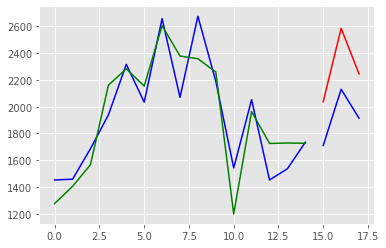

In [362]:
predictions14 = model14.predict(x_test14)
predictions_train14 = model14.predict(x_train14)

print(x_train14.shape)
print(y_train14.shape)
print(x_test14.shape)
print(y_test14.shape)
print(NN_PB_sku73.shape)

x2_14 = numpy.arange(0, 15, 1)
x3_14 = numpy.arange(15, 18, 1)

plt.plot(x2_14, y_train14, color='blue')
plt.plot(x2_14, predictions_train14, color='green')
plt.plot(x3_14, y_test14, color='blue')
plt.plot(x3_14, predictions14, color='red')

# redline - прогноз, greenline - подгонка

In [363]:
print(predictions14)

[[2037.2002]
 [2585.7063]
 [2245.1475]]


In [590]:
# -SKU#76-

In [368]:
PB_sku76 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #76')]
PB_sku76.drop('sku_id', axis=1, inplace=True)
#PB_sku76.iloc[:,1].plot()

NN_PB_sku76 = pd.DataFrame()

for i in range(10,0,-1):
    NN_PB_sku76['t-' + str(i)] = PB_sku76.iloc[:,1].shift(i)
    
NN_PB_sku76['t'] = PB_sku76.iloc[:,1].values
#print(NN_PB_sku76.head(13))

new_NN_PB_sku76 = NN_PB_sku76[10:]
#new_NN_PB_sku76.head()

y15 = new_NN_PB_sku76['t']
x15 = new_NN_PB_sku76.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train15 = x15[:3]
y_train15 = y15[:3]
x_test15 = x15[3:]
y_test15 = y15[3:]

#print(new_NN_PB_sku76.shape)
#print(x_train15.shape)
#print(y_train15.shape)
#print(x_test15.shape)
#print(y_test15.shape)
#print(x_train15.head(5))

x_train15 = x_train15.values
y_train15 = y_train15.values
x_test15 = x_test15.values
y_test15 = y_test15.values

# NN

model15 = Sequential()
model15.add(Dense(6, input_dim=10, activation='relu'))
model15.add(Dense(1, activation='linear'))
model15.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model15.fit(x_train15, y_train15, epochs=300, batch_size=None)

Epoch 1/300
3/3 [==============================] - 9s 3s/step - loss: 1195768.1250 - mean_absolute_percentage_error: 27.0367
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 1145043.3750 - mean_absolute_percentage_error: 26.4387
Epoch 3/300
3/3 [==============================] - 0s 2ms/step - loss: 1097372.3750 - mean_absolute_percentage_error: 25.8474
Epoch 4/300
3/3 [==============================] - 0s 2ms/step - loss: 1055959.6250 - mean_absolute_percentage_error: 25.3177
Epoch 5/300
3/3 [==============================] - 0s 2ms/step - loss: 1014510.9375 - mean_absolute_percentage_error: 24.7876
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 971452.7500 - mean_absolute_percentage_error: 24.2410
Epoch 7/300
3/3 [==============================] - 0s 2ms/step - loss: 930678.1875 - mean_absolute_percentage_error: 23.7249
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 890494.8125 - mean_absolute_percentage_error: 23.2

Epoch 67/300
3/3 [==============================] - 0s 3ms/step - loss: 249902.6719 - mean_absolute_percentage_error: 13.8567
Epoch 68/300
3/3 [==============================] - 0s 4ms/step - loss: 245978.6250 - mean_absolute_percentage_error: 13.6871
Epoch 69/300
3/3 [==============================] - 0s 3ms/step - loss: 242053.5781 - mean_absolute_percentage_error: 13.5481
Epoch 70/300
3/3 [==============================] - 0s 2ms/step - loss: 238105.5469 - mean_absolute_percentage_error: 13.4841
Epoch 71/300
3/3 [==============================] - 0s 8ms/step - loss: 234122.1875 - mean_absolute_percentage_error: 13.4046
Epoch 72/300
3/3 [==============================] - 0s 3ms/step - loss: 230099.5156 - mean_absolute_percentage_error: 13.3108
Epoch 73/300
3/3 [==============================] - 0s 4ms/step - loss: 226069.5156 - mean_absolute_percentage_error: 13.2043
Epoch 74/300
3/3 [==============================] - 0s 5ms/step - loss: 222669.9219 - mean_absolute_percentage_error: 

3/3 [==============================] - 0s 3ms/step - loss: 75495.8438 - mean_absolute_percentage_error: 8.2287
Epoch 133/300
3/3 [==============================] - 0s 2ms/step - loss: 73871.5000 - mean_absolute_percentage_error: 8.1360
Epoch 134/300
3/3 [==============================] - 0s 2ms/step - loss: 72563.7422 - mean_absolute_percentage_error: 8.0515
Epoch 135/300
3/3 [==============================] - 0s 2ms/step - loss: 71069.5859 - mean_absolute_percentage_error: 7.9765
Epoch 136/300
3/3 [==============================] - 0s 2ms/step - loss: 69408.0391 - mean_absolute_percentage_error: 7.9092
Epoch 137/300
3/3 [==============================] - 0s 2ms/step - loss: 68025.9141 - mean_absolute_percentage_error: 7.8455
Epoch 138/300
3/3 [==============================] - 0s 4ms/step - loss: 66600.7969 - mean_absolute_percentage_error: 7.7681
Epoch 139/300
3/3 [==============================] - 0s 2ms/step - loss: 65214.8398 - mean_absolute_percentage_error: 7.6827
Epoch 140/300


Epoch 198/300
3/3 [==============================] - 0s 4ms/step - loss: 16510.3340 - mean_absolute_percentage_error: 3.9975
Epoch 199/300
3/3 [==============================] - 0s 3ms/step - loss: 16075.8799 - mean_absolute_percentage_error: 3.9379
Epoch 200/300
3/3 [==============================] - 0s 2ms/step - loss: 15661.1846 - mean_absolute_percentage_error: 3.8897
Epoch 201/300
3/3 [==============================] - 0s 3ms/step - loss: 15291.5674 - mean_absolute_percentage_error: 3.8548
Epoch 202/300
3/3 [==============================] - 0s 3ms/step - loss: 14912.0781 - mean_absolute_percentage_error: 3.8110
Epoch 203/300
3/3 [==============================] - 0s 2ms/step - loss: 14512.7529 - mean_absolute_percentage_error: 3.7577
Epoch 204/300
3/3 [==============================] - 0s 3ms/step - loss: 14127.2705 - mean_absolute_percentage_error: 3.6997
Epoch 205/300
3/3 [==============================] - 0s 3ms/step - loss: 13764.5439 - mean_absolute_percentage_error: 3.6531


Epoch 264/300
3/3 [==============================] - 0s 2ms/step - loss: 2544.6707 - mean_absolute_percentage_error: 1.5924
Epoch 265/300
3/3 [==============================] - 0s 4ms/step - loss: 2472.6086 - mean_absolute_percentage_error: 1.5655
Epoch 266/300
3/3 [==============================] - 0s 2ms/step - loss: 2397.6128 - mean_absolute_percentage_error: 1.5414
Epoch 267/300
3/3 [==============================] - 0s 2ms/step - loss: 2316.2659 - mean_absolute_percentage_error: 1.5187
Epoch 268/300
3/3 [==============================] - 0s 4ms/step - loss: 2255.6506 - mean_absolute_percentage_error: 1.5053
Epoch 269/300
3/3 [==============================] - 0s 3ms/step - loss: 2191.6404 - mean_absolute_percentage_error: 1.4867
Epoch 270/300
3/3 [==============================] - 0s 2ms/step - loss: 2122.6855 - mean_absolute_percentage_error: 1.4628
Epoch 271/300
3/3 [==============================] - 0s 3ms/step - loss: 2049.9817 - mean_absolute_percentage_error: 1.4342
Epoch 27

In [369]:
scores15 = model15.evaluate(x_test15, y_test15)
y_pred15 = model15.predict(x_test15)

def smape(y_test15, y_pred15):
    return 100/len(y_test15) * np.sum(2 * np.abs(y_pred15 - y_test15) / (np.abs(y_test15) + np.abs(y_pred15)))

print(smape(y_test15, y_pred15))
# Подсчитали SMAPE

3/3 [==============================] - 3s 1s/step
35.69889387539299


(3, 10)
(3,)
(3, 10)
(3,)
(16, 11)


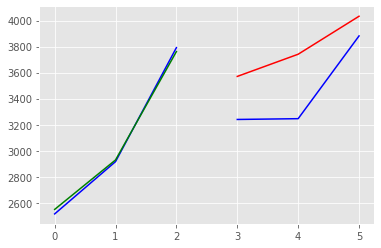

In [370]:
predictions15 = model15.predict(x_test15)
predictions_train15 = model15.predict(x_train15)

print(x_train15.shape)
print(y_train15.shape)
print(x_test15.shape)
print(y_test15.shape)
print(NN_PB_sku76.shape)

x2_15 = numpy.arange(0, 3, 1)
x3_15 = numpy.arange(3, 6, 1)

plt.plot(x2_15, y_train15, color='blue')
plt.plot(x2_15, predictions_train15, color='green')
plt.plot(x3_15, y_test15, color='blue')
plt.plot(x3_15, predictions15, color='red')

# redline - прогноз, greenline - подгонка

In [371]:
print(predictions15)

[[3570.8044]
 [3741.3667]
 [4033.331 ]]


In [601]:
# -SKU#77-

In [372]:
PB_sku77 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #77')]
PB_sku77.drop('sku_id', axis=1, inplace=True)
#PB_sku77.iloc[:,1].plot()

NN_PB_sku77 = pd.DataFrame()

for i in range(10,0,-1):
    NN_PB_sku77['t-' + str(i)] = PB_sku77.iloc[:,1].shift(i)
    
NN_PB_sku77['t'] = PB_sku77.iloc[:,1].values
#print(NN_PB_sku77.head(13))

new_NN_PB_sku77 = NN_PB_sku77[10:]
#new_NN_PB_sku77.head()

y16 = new_NN_PB_sku77['t']
x16 = new_NN_PB_sku77.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train16 = x16[:3]
y_train16 = y16[:3]
x_test16 = x16[3:]
y_test16 = y16[3:]

#print(new_NN_PB_sku77.shape)
#print(x_train16.shape)
#print(y_train16.shape)
#print(x_test16.shape)
#print(y_test16.shape)
#print(x_train16.head(5))

x_train16 = x_train16.values
y_train16 = y_train16.values
x_test16 = x_test16.values
y_test16 = y_test16.values

# NN

model16 = Sequential()
model16.add(Dense(6, input_dim=10, activation='relu'))
model16.add(Dense(1, activation='linear'))
model16.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model16.fit(x_train16, y_train16, epochs=300, batch_size=None)

Epoch 1/300
3/3 [==============================] - 9s 3s/step - loss: 655343.5625 - mean_absolute_percentage_error: 20.7728
Epoch 2/300
3/3 [==============================] - 0s 5ms/step - loss: 593140.5625 - mean_absolute_percentage_error: 20.1577
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 529696.4375 - mean_absolute_percentage_error: 19.4518
Epoch 4/300
3/3 [==============================] - 0s 2ms/step - loss: 472243.9688 - mean_absolute_percentage_error: 18.7112
Epoch 5/300
3/3 [==============================] - 0s 3ms/step - loss: 423422.0000 - mean_absolute_percentage_error: 17.9591
Epoch 6/300
3/3 [==============================] - 0s 4ms/step - loss: 384283.3750 - mean_absolute_percentage_error: 17.2103
Epoch 7/300
3/3 [==============================] - 0s 3ms/step - loss: 354242.0000 - mean_absolute_percentage_error: 16.4541
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 334634.7188 - mean_absolute_percentage_error: 15.7480
E

Epoch 67/300
3/3 [==============================] - 0s 5ms/step - loss: 110361.7266 - mean_absolute_percentage_error: 8.6732
Epoch 68/300
3/3 [==============================] - 0s 3ms/step - loss: 108118.0078 - mean_absolute_percentage_error: 8.5702
Epoch 69/300
3/3 [==============================] - 0s 2ms/step - loss: 105903.6562 - mean_absolute_percentage_error: 8.4644
Epoch 70/300
3/3 [==============================] - 0s 3ms/step - loss: 103723.6641 - mean_absolute_percentage_error: 8.3570
Epoch 71/300
3/3 [==============================] - 0s 2ms/step - loss: 101580.9766 - mean_absolute_percentage_error: 8.2493
Epoch 72/300
3/3 [==============================] - 0s 4ms/step - loss: 99476.5312 - mean_absolute_percentage_error: 8.1427
Epoch 73/300
3/3 [==============================] - 0s 3ms/step - loss: 97408.7812 - mean_absolute_percentage_error: 8.0382
Epoch 74/300
3/3 [==============================] - 0s 3ms/step - loss: 95375.2266 - mean_absolute_percentage_error: 7.9367
Epo

Epoch 133/300
3/3 [==============================] - 0s 2ms/step - loss: 21185.3750 - mean_absolute_percentage_error: 3.7419
Epoch 134/300
3/3 [==============================] - 0s 3ms/step - loss: 20564.7656 - mean_absolute_percentage_error: 3.6867
Epoch 135/300
3/3 [==============================] - 0s 2ms/step - loss: 19961.7090 - mean_absolute_percentage_error: 3.6321
Epoch 136/300
3/3 [==============================] - 0s 2ms/step - loss: 19371.7246 - mean_absolute_percentage_error: 3.5776
Epoch 137/300
3/3 [==============================] - 0s 3ms/step - loss: 18798.5684 - mean_absolute_percentage_error: 3.5237
Epoch 138/300
3/3 [==============================] - 0s 2ms/step - loss: 18240.0020 - mean_absolute_percentage_error: 3.4700
Epoch 139/300
3/3 [==============================] - 0s 4ms/step - loss: 17695.6113 - mean_absolute_percentage_error: 3.4166
Epoch 140/300
3/3 [==============================] - 0s 3ms/step - loss: 17163.4297 - mean_absolute_percentage_error: 3.3635


Epoch 199/300
3/3 [==============================] - 0s 4ms/step - loss: 2343.7268 - mean_absolute_percentage_error: 1.1761
Epoch 200/300
3/3 [==============================] - 0s 5ms/step - loss: 2261.4402 - mean_absolute_percentage_error: 1.1482
Epoch 201/300
3/3 [==============================] - 0s 5ms/step - loss: 2181.5120 - mean_absolute_percentage_error: 1.1224
Epoch 202/300
3/3 [==============================] - 0s 4ms/step - loss: 2103.9294 - mean_absolute_percentage_error: 1.0989
Epoch 203/300
3/3 [==============================] - 0s 4ms/step - loss: 2028.3287 - mean_absolute_percentage_error: 1.0775
Epoch 204/300
3/3 [==============================] - 0s 3ms/step - loss: 1954.5488 - mean_absolute_percentage_error: 1.0581
Epoch 205/300
3/3 [==============================] - 0s 3ms/step - loss: 1883.1725 - mean_absolute_percentage_error: 1.0402
Epoch 206/300
3/3 [==============================] - 0s 2ms/step - loss: 1814.2472 - mean_absolute_percentage_error: 1.0235
Epoch 20

Epoch 266/300
3/3 [==============================] - 0s 3ms/step - loss: 179.3865 - mean_absolute_percentage_error: 0.3093
Epoch 267/300
3/3 [==============================] - 0s 2ms/step - loss: 172.3625 - mean_absolute_percentage_error: 0.3034
Epoch 268/300
3/3 [==============================] - 0s 2ms/step - loss: 165.9163 - mean_absolute_percentage_error: 0.2981
Epoch 269/300
3/3 [==============================] - 0s 11ms/step - loss: 159.0741 - mean_absolute_percentage_error: 0.2938
Epoch 270/300
3/3 [==============================] - 0s 2ms/step - loss: 152.8396 - mean_absolute_percentage_error: 0.2898
Epoch 271/300
3/3 [==============================] - 0s 5ms/step - loss: 146.8712 - mean_absolute_percentage_error: 0.2857
Epoch 272/300
3/3 [==============================] - 0s 2ms/step - loss: 141.1442 - mean_absolute_percentage_error: 0.2815
Epoch 273/300
3/3 [==============================] - 0s 3ms/step - loss: 135.6321 - mean_absolute_percentage_error: 0.2771
Epoch 274/300
3

In [373]:
scores16 = model16.evaluate(x_test16, y_test16)
y_pred16 = model16.predict(x_test16)

def smape(y_test16, y_pred16):
    return 100/len(y_test16) * np.sum(2 * np.abs(y_pred16 - y_test16) / (np.abs(y_test16) + np.abs(y_pred16)))

print(smape(y_test16, y_pred16))
# Подсчитали SMAPE

3/3 [==============================] - 3s 1s/step
67.06222835671399


(3, 10)
(3,)
(3, 10)
(3,)
(16, 11)


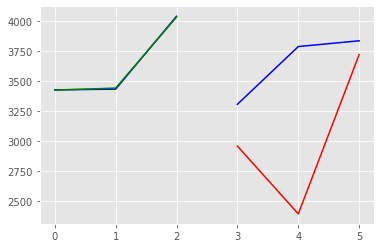

In [374]:
predictions16 = model16.predict(x_test16)
predictions_train16 = model16.predict(x_train16)

print(x_train16.shape)
print(y_train16.shape)
print(x_test16.shape)
print(y_test16.shape)
print(NN_PB_sku77.shape)

x2_16 = numpy.arange(0, 3, 1)
x3_16 = numpy.arange(3, 6, 1)

plt.plot(x2_16, y_train16, color='blue')
plt.plot(x2_16, predictions_train16, color='green')
plt.plot(x3_16, y_test16, color='blue')
plt.plot(x3_16, predictions16, color='red')

# redline - прогноз, greenline - подгонка

In [375]:
print(predictions16)

[[2958.5012]
 [2394.7522]
 [3719.5256]]


In [611]:
# -SKU#78-

In [396]:
PB_sku78 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #78')]
PB_sku78.drop('sku_id', axis=1, inplace=True)
#PB_sku78.iloc[:,1].plot()

NN_PB_sku78 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku78['t-' + str(i)] = PB_sku78.iloc[:,1].shift(i)
    
NN_PB_sku78['t'] = PB_sku78.iloc[:,1].values
#print(NN_PB_sku78.head(13))

new_NN_PB_sku78 = NN_PB_sku78[12:]
#new_NN_PB_sku78.head()

y17 = new_NN_PB_sku78['t']
x17 = new_NN_PB_sku78.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train17 = x17[:14]
y_train17 = y17[:14]
x_test17 = x17[14:]
y_test17 = y17[14:]

#print(new_NN_PB_sku78.shape)
#print(x_train17.shape)
#print(y_train17.shape)
#print(x_test17.shape)
#print(y_test17.shape)
#print(x_train17.head(5))

x_train17 = x_train17.values
y_train17 = y_train17.values
x_test17 = x_test17.values
y_test17 = y_test17.values

# NN

model17 = Sequential()
model17.add(Dense(6, input_dim=12, activation='relu'))
model17.add(Dense(1, activation='linear'))
model17.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model17.fit(x_train17, y_train17, epochs=300, batch_size=None)

Epoch 1/300
14/14 [==============================] - 9s 665ms/step - loss: 303839.9688 - mean_absolute_percentage_error: 178.7301
Epoch 2/300
14/14 [==============================] - 0s 499us/step - loss: 300329.3438 - mean_absolute_percentage_error: 177.5897
Epoch 3/300
14/14 [==============================] - 0s 499us/step - loss: 295784.8125 - mean_absolute_percentage_error: 176.1226
Epoch 4/300
14/14 [==============================] - 0s 570us/step - loss: 291706.1562 - mean_absolute_percentage_error: 174.7948
Epoch 5/300
14/14 [==============================] - 0s 499us/step - loss: 287564.2188 - mean_absolute_percentage_error: 173.4351
Epoch 6/300
14/14 [==============================] - 0s 2ms/step - loss: 283397.0625 - mean_absolute_percentage_error: 172.0557
Epoch 7/300
14/14 [==============================] - 0s 855us/step - loss: 279104.0312 - mean_absolute_percentage_error: 170.6226
Epoch 8/300
14/14 [==============================] - 0s 570us/step - loss: 275080.7188 - mea

Epoch 64/300
14/14 [==============================] - 0s 926us/step - loss: 83007.2266 - mean_absolute_percentage_error: 71.7922
Epoch 65/300
14/14 [==============================] - 0s 570us/step - loss: 80589.8516 - mean_absolute_percentage_error: 70.1040
Epoch 66/300
14/14 [==============================] - 0s 499us/step - loss: 78119.4141 - mean_absolute_percentage_error: 68.3825
Epoch 67/300
14/14 [==============================] - 0s 926us/step - loss: 75721.7734 - mean_absolute_percentage_error: 66.6278
Epoch 68/300
14/14 [==============================] - 0s 430us/step - loss: 73320.9844 - mean_absolute_percentage_error: 64.8405
Epoch 69/300
14/14 [==============================] - 0s 642us/step - loss: 70956.8906 - mean_absolute_percentage_error: 63.0561
Epoch 70/300
14/14 [==============================] - 0s 786us/step - loss: 68658.1641 - mean_absolute_percentage_error: 61.6408
Epoch 71/300
14/14 [==============================] - 0s 855us/step - loss: 66445.2891 - mean_abs

Epoch 128/300
14/14 [==============================] - 0s 427us/step - loss: 27881.1582 - mean_absolute_percentage_error: 48.5294
Epoch 129/300
14/14 [==============================] - 0s 570us/step - loss: 27787.0254 - mean_absolute_percentage_error: 48.4315
Epoch 130/300
14/14 [==============================] - 0s 570us/step - loss: 27693.0762 - mean_absolute_percentage_error: 48.3297
Epoch 131/300
14/14 [==============================] - 0s 570us/step - loss: 27599.0898 - mean_absolute_percentage_error: 48.2241
Epoch 132/300
14/14 [==============================] - 0s 785us/step - loss: 27505.8691 - mean_absolute_percentage_error: 48.1162
Epoch 133/300
14/14 [==============================] - 0s 639us/step - loss: 27413.1680 - mean_absolute_percentage_error: 48.0061
Epoch 134/300
14/14 [==============================] - 0s 2ms/step - loss: 27321.0762 - mean_absolute_percentage_error: 47.8944
Epoch 135/300
14/14 [==============================] - 0s 570us/step - loss: 27229.3711 - me

14/14 [==============================] - 0s 1ms/step - loss: 23074.6973 - mean_absolute_percentage_error: 43.4316
Epoch 192/300
14/14 [==============================] - 0s 570us/step - loss: 23011.7598 - mean_absolute_percentage_error: 43.3780
Epoch 193/300
14/14 [==============================] - 0s 784us/step - loss: 22949.1230 - mean_absolute_percentage_error: 43.3243
Epoch 194/300
14/14 [==============================] - 0s 427us/step - loss: 22886.7910 - mean_absolute_percentage_error: 43.2706
Epoch 195/300
14/14 [==============================] - 0s 855us/step - loss: 22824.6133 - mean_absolute_percentage_error: 43.2169
Epoch 196/300
14/14 [==============================] - 0s 855us/step - loss: 22762.8887 - mean_absolute_percentage_error: 43.1632
Epoch 197/300
14/14 [==============================] - 0s 499us/step - loss: 22701.4551 - mean_absolute_percentage_error: 43.1095
Epoch 198/300
14/14 [==============================] - 0s 498us/step - loss: 22640.3184 - mean_absolute_pe

Epoch 255/300
14/14 [==============================] - 0s 1ms/step - loss: 19592.0352 - mean_absolute_percentage_error: 40.1386
Epoch 256/300
14/14 [==============================] - 0s 499us/step - loss: 19545.1875 - mean_absolute_percentage_error: 40.0907
Epoch 257/300
14/14 [==============================] - 0s 641us/step - loss: 19498.5352 - mean_absolute_percentage_error: 40.0431
Epoch 258/300
14/14 [==============================] - 0s 641us/step - loss: 19452.0664 - mean_absolute_percentage_error: 39.9956
Epoch 259/300
14/14 [==============================] - 0s 784us/step - loss: 19405.7129 - mean_absolute_percentage_error: 39.9482
Epoch 260/300
14/14 [==============================] - 0s 1ms/step - loss: 19359.6211 - mean_absolute_percentage_error: 39.9010
Epoch 261/300
14/14 [==============================] - 0s 570us/step - loss: 19313.7188 - mean_absolute_percentage_error: 39.8540
Epoch 262/300
14/14 [==============================] - 0s 784us/step - loss: 19268.0059 - mean

In [391]:
scores17 = model17.evaluate(x_test17, y_test17)
y_pred17 = model17.predict(x_test17)

def smape(y_test17, y_pred17):
    return 100/len(y_test17) * np.sum(2 * np.abs(y_pred17 - y_test17) / (np.abs(y_test17) + np.abs(y_pred17)))

print(smape(y_test17, y_pred17))
# Подсчитали SMAPE

3/3 [==============================] - 3s 1s/step
113.42658374873557


(14, 12)
(14,)
(3, 12)
(3,)
(29, 13)


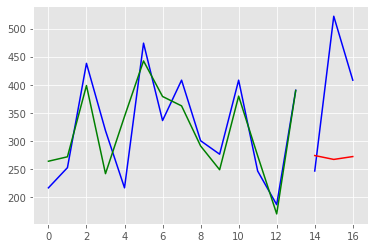

In [392]:
predictions17 = model17.predict(x_test17)
predictions_train17 = model17.predict(x_train17)

print(x_train17.shape)
print(y_train17.shape)
print(x_test17.shape)
print(y_test17.shape)
print(NN_PB_sku78.shape)

x2_17 = numpy.arange(0, 14, 1)
x3_17 = numpy.arange(14, 17, 1)

plt.plot(x2_17, y_train17, color='blue')
plt.plot(x2_17, predictions_train17, color='green')
plt.plot(x3_17, y_test17, color='blue')
plt.plot(x3_17, predictions17, color='red')

# redline - прогноз, greenline - подгонка

In [393]:
print(predictions17)

[[273.6258]
 [266.6859]
 [271.7818]]


In [618]:
# -SKU#79-

In [412]:
PB_sku79 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #79')]
PB_sku79.drop('sku_id', axis=1, inplace=True)
#PB_sku79.iloc[:,1].plot()

NN_PB_sku79 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku79['t-' + str(i)] = PB_sku79.iloc[:,1].shift(i)
    
NN_PB_sku79['t'] = PB_sku79.iloc[:,1].values
#print(NN_PB_sku79.head(13))

new_NN_PB_sku79 = NN_PB_sku79[12:]
#new_NN_PB_sku79.head()

y18 = new_NN_PB_sku79['t']
x18 = new_NN_PB_sku79.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train18 = x18[:15]
y_train18 = y18[:15]
x_test18 = x18[15:]
y_test18 = y18[15:]

#print(new_NN_PB_sku79.shape)
#print(x_train18.shape)
#print(y_train18.shape)
#print(x_test18.shape)
#print(y_test18.shape)
#print(x_train18.head(5))

x_train18 = x_train18.values
y_train18 = y_train18.values
x_test18 = x_test18.values
y_test18 = y_test18.values

# NN

model18 = Sequential()
model18.add(Dense(6, input_dim=12, activation='relu'))
model18.add(Dense(1, activation='linear'))
model18.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model18.fit(x_train18, y_train18, epochs=300, batch_size=None)

Epoch 1/300
15/15 [==============================] - 10s 640ms/step - loss: 290374.6250 - mean_absolute_percentage_error: 76.1635
Epoch 2/300
15/15 [==============================] - 0s 464us/step - loss: 287776.4062 - mean_absolute_percentage_error: 75.7417
Epoch 3/300
15/15 [==============================] - 0s 528us/step - loss: 285187.4062 - mean_absolute_percentage_error: 75.3305
Epoch 4/300
15/15 [==============================] - 0s 532us/step - loss: 282607.8750 - mean_absolute_percentage_error: 74.9164
Epoch 5/300
15/15 [==============================] - 0s 597us/step - loss: 279916.7812 - mean_absolute_percentage_error: 74.4840
Epoch 6/300
15/15 [==============================] - 0s 732us/step - loss: 277062.9375 - mean_absolute_percentage_error: 74.0262
Epoch 7/300
15/15 [==============================] - 0s 598us/step - loss: 274090.5625 - mean_absolute_percentage_error: 73.5513
Epoch 8/300
15/15 [==============================] - 0s 997us/step - loss: 270921.5312 - mean_ab

Epoch 65/300
15/15 [==============================] - 0s 465us/step - loss: 103061.2891 - mean_absolute_percentage_error: 43.8871
Epoch 66/300
15/15 [==============================] - 0s 396us/step - loss: 101584.0547 - mean_absolute_percentage_error: 43.5497
Epoch 67/300
15/15 [==============================] - 0s 532us/step - loss: 100186.5469 - mean_absolute_percentage_error: 43.2991
Epoch 68/300
15/15 [==============================] - 0s 465us/step - loss: 98866.1406 - mean_absolute_percentage_error: 43.0523
Epoch 69/300
15/15 [==============================] - 0s 864us/step - loss: 97620.0859 - mean_absolute_percentage_error: 42.9194
Epoch 70/300
15/15 [==============================] - 0s 2ms/step - loss: 96445.4844 - mean_absolute_percentage_error: 42.7891
Epoch 71/300
15/15 [==============================] - 0s 796us/step - loss: 95339.4531 - mean_absolute_percentage_error: 42.6600
Epoch 72/300
15/15 [==============================] - 0s 798us/step - loss: 94298.8359 - mean_ab

Epoch 129/300
15/15 [==============================] - 0s 530us/step - loss: 69907.3203 - mean_absolute_percentage_error: 37.6938
Epoch 130/300
15/15 [==============================] - 0s 465us/step - loss: 69584.7109 - mean_absolute_percentage_error: 37.6246
Epoch 131/300
15/15 [==============================] - 0s 733us/step - loss: 69265.8672 - mean_absolute_percentage_error: 37.5555
Epoch 132/300
15/15 [==============================] - 0s 799us/step - loss: 68949.6094 - mean_absolute_percentage_error: 37.4862
Epoch 133/300
15/15 [==============================] - 0s 463us/step - loss: 68634.8125 - mean_absolute_percentage_error: 37.4166
Epoch 134/300
15/15 [==============================] - 0s 731us/step - loss: 68323.6328 - mean_absolute_percentage_error: 37.3471
Epoch 135/300
15/15 [==============================] - 0s 597us/step - loss: 68013.8906 - mean_absolute_percentage_error: 37.2773
Epoch 136/300
15/15 [==============================] - 0s 799us/step - loss: 67707.6953 - 

15/15 [==============================] - 0s 467us/step - loss: 53784.7227 - mean_absolute_percentage_error: 33.5773
Epoch 193/300
15/15 [==============================] - 0s 665us/step - loss: 53582.8789 - mean_absolute_percentage_error: 33.5192
Epoch 194/300
15/15 [==============================] - 0s 598us/step - loss: 53382.3594 - mean_absolute_percentage_error: 33.4612
Epoch 195/300
15/15 [==============================] - 0s 798us/step - loss: 53183.1406 - mean_absolute_percentage_error: 33.4035
Epoch 196/300
15/15 [==============================] - 0s 397us/step - loss: 52985.2227 - mean_absolute_percentage_error: 33.3460
Epoch 197/300
15/15 [==============================] - 0s 665us/step - loss: 52788.5820 - mean_absolute_percentage_error: 33.2887
Epoch 198/300
15/15 [==============================] - 0s 530us/step - loss: 52593.2148 - mean_absolute_percentage_error: 33.2316
Epoch 199/300
15/15 [==============================] - 0s 897us/step - loss: 52399.1133 - mean_absolute_

Epoch 256/300
15/15 [==============================] - 0s 665us/step - loss: 43083.8516 - mean_absolute_percentage_error: 30.2031
Epoch 257/300
15/15 [==============================] - 0s 798us/step - loss: 42946.3164 - mean_absolute_percentage_error: 30.1550
Epoch 258/300
15/15 [==============================] - 0s 665us/step - loss: 42809.3086 - mean_absolute_percentage_error: 30.1070
Epoch 259/300
15/15 [==============================] - 0s 798us/step - loss: 42673.2891 - mean_absolute_percentage_error: 30.0592
Epoch 260/300
15/15 [==============================] - 0s 532us/step - loss: 42538.0000 - mean_absolute_percentage_error: 30.0114
Epoch 261/300
15/15 [==============================] - 0s 665us/step - loss: 42403.4492 - mean_absolute_percentage_error: 29.9639
Epoch 262/300
15/15 [==============================] - 0s 598us/step - loss: 42269.6250 - mean_absolute_percentage_error: 29.9164
Epoch 263/300
15/15 [==============================] - 0s 596us/step - loss: 42136.5352 - 

In [403]:
scores18 = model18.evaluate(x_test18, y_test18)
y_pred18 = model18.predict(x_test18)

def smape(y_test18, y_pred18):
    return 100/len(y_test18) * np.sum(2 * np.abs(y_pred18 - y_test18) / (np.abs(y_test18) + np.abs(y_pred18)))

print(smape(y_test18, y_pred18))
# Подсчитали SMAPE

3/3 [==============================] - 4s 1s/step
38.21028324407177


(15, 12)
(15,)
(3, 12)
(3,)
(30, 13)


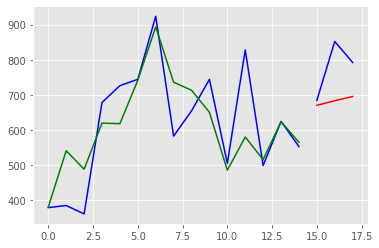

In [404]:
predictions18 = model18.predict(x_test18)
predictions_train18 = model18.predict(x_train18)

print(x_train18.shape)
print(y_train18.shape)
print(x_test18.shape)
print(y_test18.shape)
print(NN_PB_sku79.shape)

x2_18 = numpy.arange(0, 15, 1)
x3_18 = numpy.arange(15, 18, 1)

plt.plot(x2_18, y_train18, color='blue')
plt.plot(x2_18, predictions_train18, color='green')
plt.plot(x3_18, y_test18, color='blue')
plt.plot(x3_18, predictions18, color='red')

# redline - прогноз, greenline - подгонка

In [405]:
print(predictions18)

[[669.86255]
 [682.91846]
 [695.1679 ]]


In [627]:
# -SKU#94-

In [421]:
PB_sku94 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #94')]
PB_sku94.drop('sku_id', axis=1, inplace=True)
#PB_sku94.iloc[:,1].plot()

NN_PB_sku94 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku94['t-' + str(i)] = PB_sku94.iloc[:,1].shift(i)
    
NN_PB_sku94['t'] = PB_sku94.iloc[:,1].values
#print(NN_PB_sku94.head(13))

new_NN_PB_sku94 = NN_PB_sku94[12:]
#new_NN_PB_sku94.head()

y19 = new_NN_PB_sku94['t']
x19 = new_NN_PB_sku94.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train19 = x19[:4]
y_train19 = y19[:4]
x_test19 = x19[4:]
y_test19 = y19[4:]

#print(new_NN_PB_sku94.shape)
#print(x_train19.shape)
#print(y_train19.shape)
#print(x_test19.shape)
#print(y_test19.shape)
#print(x_train19.head(5))

x_train19 = x_train19.values
y_train19 = y_train19.values
x_test19 = x_test19.values
y_test19 = y_test19.values

# NN

model19 = Sequential()
model19.add(Dense(6, input_dim=12, activation='relu'))
model19.add(Dense(1, activation='linear'))
model19.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model19.fit(x_train19, y_train19, epochs=300, batch_size=None)

Epoch 1/300
4/4 [==============================] - 10s 2s/step - loss: 42394.2227 - mean_absolute_percentage_error: 31.9877
Epoch 2/300
4/4 [==============================] - 0s 1ms/step - loss: 39886.6055 - mean_absolute_percentage_error: 30.8099
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 37459.6133 - mean_absolute_percentage_error: 29.6293
Epoch 4/300
4/4 [==============================] - 0s 2ms/step - loss: 35115.6562 - mean_absolute_percentage_error: 28.4467
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 32857.0352 - mean_absolute_percentage_error: 27.2631
Epoch 6/300
4/4 [==============================] - 0s 8ms/step - loss: 30685.8809 - mean_absolute_percentage_error: 26.0795
Epoch 7/300
4/4 [==============================] - 0s 3ms/step - loss: 28604.0703 - mean_absolute_percentage_error: 24.8968
Epoch 8/300
4/4 [==============================] - 0s 3ms/step - loss: 26661.1504 - mean_absolute_percentage_error: 23.8153
Epoch 9/

Epoch 68/300
4/4 [==============================] - 0s 2ms/step - loss: 648.5718 - mean_absolute_percentage_error: 5.6460
Epoch 69/300
4/4 [==============================] - 0s 3ms/step - loss: 604.4983 - mean_absolute_percentage_error: 5.4811
Epoch 70/300
4/4 [==============================] - 0s 3ms/step - loss: 563.0565 - mean_absolute_percentage_error: 5.3217
Epoch 71/300
4/4 [==============================] - 0s 2ms/step - loss: 523.9110 - mean_absolute_percentage_error: 5.1663
Epoch 72/300
4/4 [==============================] - 0s 3ms/step - loss: 487.0483 - mean_absolute_percentage_error: 5.0149
Epoch 73/300
4/4 [==============================] - 0s 2ms/step - loss: 452.4377 - mean_absolute_percentage_error: 4.8674
Epoch 74/300
4/4 [==============================] - 0s 3ms/step - loss: 420.0364 - mean_absolute_percentage_error: 4.7235
Epoch 75/300
4/4 [==============================] - 0s 3ms/step - loss: 389.7915 - mean_absolute_percentage_error: 4.5832
Epoch 76/300
4/4 [======

Epoch 136/300
4/4 [==============================] - 0s 2ms/step - loss: 11.7365 - mean_absolute_percentage_error: 0.8216
Epoch 137/300
4/4 [==============================] - 0s 2ms/step - loss: 11.0910 - mean_absolute_percentage_error: 0.7977
Epoch 138/300
4/4 [==============================] - 0s 3ms/step - loss: 10.4765 - mean_absolute_percentage_error: 0.7740
Epoch 139/300
4/4 [==============================] - 0s 6ms/step - loss: 9.8923 - mean_absolute_percentage_error: 0.7506
Epoch 140/300
4/4 [==============================] - 0s 2ms/step - loss: 9.3377 - mean_absolute_percentage_error: 0.7275
Epoch 141/300
4/4 [==============================] - 0s 2ms/step - loss: 8.8123 - mean_absolute_percentage_error: 0.7047
Epoch 142/300
4/4 [==============================] - 0s 3ms/step - loss: 8.3153 - mean_absolute_percentage_error: 0.6824
Epoch 143/300
4/4 [==============================] - 0s 2ms/step - loss: 7.8459 - mean_absolute_percentage_error: 0.6605
Epoch 144/300
4/4 [==========

Epoch 204/300
4/4 [==============================] - 0s 2ms/step - loss: 0.3995 - mean_absolute_percentage_error: 0.1377
Epoch 205/300
4/4 [==============================] - 0s 2ms/step - loss: 0.3813 - mean_absolute_percentage_error: 0.1346
Epoch 206/300
4/4 [==============================] - 0s 3ms/step - loss: 0.3639 - mean_absolute_percentage_error: 0.1315
Epoch 207/300
4/4 [==============================] - 0s 2ms/step - loss: 0.3472 - mean_absolute_percentage_error: 0.1285
Epoch 208/300
4/4 [==============================] - 0s 1ms/step - loss: 0.3313 - mean_absolute_percentage_error: 0.1255
Epoch 209/300
4/4 [==============================] - 0s 3ms/step - loss: 0.3160 - mean_absolute_percentage_error: 0.1226
Epoch 210/300
4/4 [==============================] - 0s 2ms/step - loss: 0.3014 - mean_absolute_percentage_error: 0.1198
Epoch 211/300
4/4 [==============================] - 0s 3ms/step - loss: 0.2874 - mean_absolute_percentage_error: 0.1170
Epoch 212/300
4/4 [=============

Epoch 272/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0112 - mean_absolute_percentage_error: 0.0231
Epoch 273/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0106 - mean_absolute_percentage_error: 0.0225
Epoch 274/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0099 - mean_absolute_percentage_error: 0.0218
Epoch 275/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_absolute_percentage_error: 0.0211
Epoch 276/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_absolute_percentage_error: 0.0205
Epoch 277/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0083 - mean_absolute_percentage_error: 0.0199
Epoch 278/300
4/4 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_absolute_percentage_error: 0.0193
Epoch 279/300
4/4 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_absolute_percentage_error: 0.0187
Epoch 280/300
4/4 [=============

In [422]:
scores19 = model19.evaluate(x_test19, y_test19)
y_pred19 = model19.predict(x_test19)

def smape(y_test19, y_pred19):
    return 100/len(y_test19) * np.sum(2 * np.abs(y_pred19 - y_test19) / (np.abs(y_test19) + np.abs(y_pred19)))

print(smape(y_test19, y_pred19))
# Подсчитали SMAPE

3/3 [==============================] - 4s 1s/step
338.05450311287126


(4, 12)
(4,)
(3, 12)
(3,)
(19, 13)


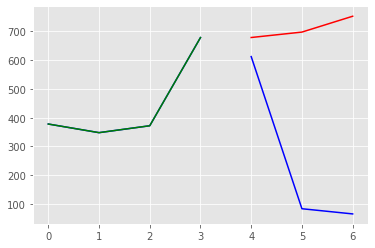

In [423]:
predictions19 = model19.predict(x_test19)
predictions_train19 = model19.predict(x_train19)

print(x_train19.shape)
print(y_train19.shape)
print(x_test19.shape)
print(y_test19.shape)
print(NN_PB_sku94.shape)

x2_19 = numpy.arange(0, 4, 1)
x3_19 = numpy.arange(4, 7, 1)

plt.plot(x2_19, y_train19, color='blue')
plt.plot(x2_19, predictions_train19, color='green')
plt.plot(x3_19, y_test19, color='blue')
plt.plot(x3_19, predictions19, color='red')

# redline - прогноз, greenline - подгонка

In [424]:
print(predictions19)

[[678.2381 ]
 [697.05493]
 [752.03735]]


In [634]:
#97 -SKU#97-

In [439]:
PB_sku97 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #97')]
PB_sku97.drop('sku_id', axis=1, inplace=True)
#PB_sku97.iloc[:,1].plot()

NN_PB_sku97 = pd.DataFrame()

for i in range(10,0,-1):
    NN_PB_sku97['t-' + str(i)] = PB_sku97.iloc[:,1].shift(i)
    
NN_PB_sku97['t'] = PB_sku97.iloc[:,1].values
#print(NN_PB_sku97.head(13))

new_NN_PB_sku97 = NN_PB_sku97[10:]
#new_NN_PB_sku97.head()

y20 = new_NN_PB_sku97['t']
x20 = new_NN_PB_sku97.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train20 = x20[:3]
y_train20 = y20[:3]
x_test20 = x20[3:]
y_test20 = y20[3:]

#print(new_NN_PB_sku97.shape)
#print(x_train20.shape)
#print(y_train20.shape)
#print(x_test20.shape)
#print(y_test20.shape)
#print(x_train20.head(5))

x_train20 = x_train20.values
y_train20 = y_train20.values
x_test20 = x_test20.values
y_test20 = y_test20.values

# NN

model20 = Sequential()
model20.add(Dense(6, input_dim=10, activation='relu'))
model20.add(Dense(1, activation='linear'))
model20.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model20.fit(x_train20, y_train20, epochs=300, batch_size=None)

Epoch 1/300
3/3 [==============================] - 10s 3s/step - loss: 1945779.3750 - mean_absolute_percentage_error: 25.9161
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 1727090.0000 - mean_absolute_percentage_error: 24.1552
Epoch 3/300
3/3 [==============================] - 0s 3ms/step - loss: 1496934.8750 - mean_absolute_percentage_error: 22.1317
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 1279191.2500 - mean_absolute_percentage_error: 20.0030
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 1082780.8750 - mean_absolute_percentage_error: 18.3458
Epoch 6/300
3/3 [==============================] - 0s 3ms/step - loss: 911832.1875 - mean_absolute_percentage_error: 17.3883
Epoch 7/300
3/3 [==============================] - 0s 4ms/step - loss: 768205.9375 - mean_absolute_percentage_error: 16.4387
Epoch 8/300
3/3 [==============================] - 0s 3ms/step - loss: 652335.0000 - mean_absolute_percentage_error: 15.

Epoch 67/300
3/3 [==============================] - 0s 3ms/step - loss: 344253.5938 - mean_absolute_percentage_error: 10.2326
Epoch 68/300
3/3 [==============================] - 0s 5ms/step - loss: 342103.6250 - mean_absolute_percentage_error: 10.2557
Epoch 69/300
3/3 [==============================] - 0s 3ms/step - loss: 340033.6250 - mean_absolute_percentage_error: 10.2755
Epoch 70/300
3/3 [==============================] - 0s 4ms/step - loss: 338026.5312 - mean_absolute_percentage_error: 10.2903
Epoch 71/300
3/3 [==============================] - 0s 4ms/step - loss: 336062.2812 - mean_absolute_percentage_error: 10.2990
Epoch 72/300
3/3 [==============================] - 0s 3ms/step - loss: 334116.0312 - mean_absolute_percentage_error: 10.3007
Epoch 73/300
3/3 [==============================] - 0s 5ms/step - loss: 332166.2500 - mean_absolute_percentage_error: 10.2948
Epoch 74/300
3/3 [==============================] - 0s 4ms/step - loss: 330195.5312 - mean_absolute_percentage_error: 

Epoch 133/300
3/3 [==============================] - 0s 4ms/step - loss: 213031.7500 - mean_absolute_percentage_error: 8.1417
Epoch 134/300
3/3 [==============================] - 0s 4ms/step - loss: 211218.9375 - mean_absolute_percentage_error: 8.1081
Epoch 135/300
3/3 [==============================] - 0s 3ms/step - loss: 209414.0469 - mean_absolute_percentage_error: 8.0739
Epoch 136/300
3/3 [==============================] - 0s 3ms/step - loss: 207616.5000 - mean_absolute_percentage_error: 8.0393
Epoch 137/300
3/3 [==============================] - 0s 4ms/step - loss: 205826.7969 - mean_absolute_percentage_error: 8.0043
Epoch 138/300
3/3 [==============================] - 0s 3ms/step - loss: 204038.4531 - mean_absolute_percentage_error: 7.9689
Epoch 139/300
3/3 [==============================] - 0s 4ms/step - loss: 202274.5469 - mean_absolute_percentage_error: 7.9335
Epoch 140/300
3/3 [==============================] - 0s 3ms/step - loss: 200528.5000 - mean_absolute_percentage_error:

Epoch 199/300
3/3 [==============================] - 0s 4ms/step - loss: 112794.3438 - mean_absolute_percentage_error: 5.9379
Epoch 200/300
3/3 [==============================] - 0s 2ms/step - loss: 111574.9453 - mean_absolute_percentage_error: 5.9007
Epoch 201/300
3/3 [==============================] - 0s 4ms/step - loss: 110364.5391 - mean_absolute_percentage_error: 5.8634
Epoch 202/300
3/3 [==============================] - 0s 3ms/step - loss: 109163.0625 - mean_absolute_percentage_error: 5.8262
Epoch 203/300
3/3 [==============================] - 0s 3ms/step - loss: 108036.0703 - mean_absolute_percentage_error: 5.7922
Epoch 204/300
3/3 [==============================] - 0s 3ms/step - loss: 106798.8359 - mean_absolute_percentage_error: 5.7680
Epoch 205/300
3/3 [==============================] - 0s 3ms/step - loss: 105640.9141 - mean_absolute_percentage_error: 5.7451
Epoch 206/300
3/3 [==============================] - 0s 12ms/step - loss: 104488.5859 - mean_absolute_percentage_error

Epoch 265/300
3/3 [==============================] - 0s 3ms/step - loss: 51123.9531 - mean_absolute_percentage_error: 4.0009
Epoch 266/300
3/3 [==============================] - 0s 3ms/step - loss: 50449.2148 - mean_absolute_percentage_error: 3.9701
Epoch 267/300
3/3 [==============================] - 0s 3ms/step - loss: 49782.3164 - mean_absolute_percentage_error: 3.9392
Epoch 268/300
3/3 [==============================] - 0s 3ms/step - loss: 49121.5977 - mean_absolute_percentage_error: 3.9085
Epoch 269/300
3/3 [==============================] - 0s 4ms/step - loss: 48510.9062 - mean_absolute_percentage_error: 3.8810
Epoch 270/300
3/3 [==============================] - 0s 10ms/step - loss: 47830.6094 - mean_absolute_percentage_error: 3.8604
Epoch 271/300
3/3 [==============================] - 0s 3ms/step - loss: 47200.2031 - mean_absolute_percentage_error: 3.8415
Epoch 272/300
3/3 [==============================] - 0s 4ms/step - loss: 46576.1680 - mean_absolute_percentage_error: 3.8213

In [440]:
scores20 = model20.evaluate(x_test20, y_test20)
y_pred20 = model20.predict(x_test20)

def smape(y_test20, y_pred20):
    return 100/len(y_test20) * np.sum(2 * np.abs(y_pred20 - y_test20) / (np.abs(y_test20) + np.abs(y_pred20)))

print(smape(y_test20, y_pred20))
# Подсчитали SMAPE

3/3 [==============================] - 4s 1s/step
62.029485864948725


(3, 10)
(3,)
(3, 10)
(3,)
(16, 11)


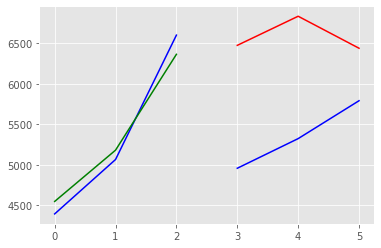

In [441]:
predictions20 = model20.predict(x_test20)
predictions_train20 = model20.predict(x_train20)

print(x_train20.shape)
print(y_train20.shape)
print(x_test20.shape)
print(y_test20.shape)
print(NN_PB_sku97.shape)

x2_20 = numpy.arange(0, 3, 1)
x3_20 = numpy.arange(3, 6, 1)

plt.plot(x2_20, y_train20, color='blue')
plt.plot(x2_20, predictions_train20, color='green')
plt.plot(x3_20, y_test20, color='blue')
plt.plot(x3_20, predictions20, color='red')

# redline - прогноз, greenline - подгонка

In [442]:
print(predictions20)

[[6473.921 ]
 [6833.3604]
 [6438.118 ]]


In [ ]:
# -SKU#100-

In [444]:
PB_sku100 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #100')]
PB_sku100.drop('sku_id', axis=1, inplace=True)
#PB_sku100.iloc[:,1].plot()

NN_PB_sku100 = pd.DataFrame()

for i in range(10,0,-1):
    NN_PB_sku100['t-' + str(i)] = PB_sku100.iloc[:,1].shift(i)
    
NN_PB_sku100['t'] = PB_sku100.iloc[:,1].values
#print(NN_PB_sku100.head(13))

new_NN_PB_sku100 = NN_PB_sku100[10:]
#new_NN_PB_sku100.head()

y21 = new_NN_PB_sku100['t']
x21 = new_NN_PB_sku100.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train21 = x21[:3]
y_train21 = y21[:3]
x_test21 = x21[3:]
y_test21 = y21[3:]

#print(new_NN_PB_sku100.shape)
#print(x_train21.shape)
#print(y_train21.shape)
#print(x_test21.shape)
#print(y_test21.shape)
#print(x_train21.head(5))

x_train21 = x_train21.values
y_train21 = y_train21.values
x_test21 = x_test21.values
y_test21 = y_test21.values

# NN

model21 = Sequential()
model21.add(Dense(6, input_dim=10, activation='relu'))
model21.add(Dense(1, activation='linear'))
model21.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model21.fit(x_train21, y_train21, epochs=300, batch_size=None)

Epoch 1/300
3/3 [==============================] - 10s 3s/step - loss: 924480.5000 - mean_absolute_percentage_error: 41.6678
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 896642.4375 - mean_absolute_percentage_error: 40.7696
Epoch 3/300
3/3 [==============================] - 0s 3ms/step - loss: 865346.0000 - mean_absolute_percentage_error: 39.7337
Epoch 4/300
3/3 [==============================] - 0s 3ms/step - loss: 833156.6875 - mean_absolute_percentage_error: 38.6371
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 798946.0625 - mean_absolute_percentage_error: 37.4341
Epoch 6/300
3/3 [==============================] - 0s 5ms/step - loss: 767370.6875 - mean_absolute_percentage_error: 36.2864
Epoch 7/300
3/3 [==============================] - 0s 3ms/step - loss: 735615.7500 - mean_absolute_percentage_error: 35.0927
Epoch 8/300
3/3 [==============================] - 0s 4ms/step - loss: 707096.8125 - mean_absolute_percentage_error: 33.9361


3/3 [==============================] - 0s 12ms/step - loss: 112215.5000 - mean_absolute_percentage_error: 17.1691
Epoch 67/300
3/3 [==============================] - 0s 3ms/step - loss: 108500.5000 - mean_absolute_percentage_error: 16.9344
Epoch 68/300
3/3 [==============================] - 0s 3ms/step - loss: 105188.3984 - mean_absolute_percentage_error: 16.7131
Epoch 69/300
3/3 [==============================] - 0s 4ms/step - loss: 101847.7578 - mean_absolute_percentage_error: 16.4707
Epoch 70/300
3/3 [==============================] - 0s 7ms/step - loss: 98403.6328 - mean_absolute_percentage_error: 16.2057
Epoch 71/300
3/3 [==============================] - 0s 4ms/step - loss: 95347.0078 - mean_absolute_percentage_error: 15.9596
Epoch 72/300
3/3 [==============================] - 0s 3ms/step - loss: 92364.6172 - mean_absolute_percentage_error: 15.7134
Epoch 73/300
3/3 [==============================] - 0s 3ms/step - loss: 89493.3984 - mean_absolute_percentage_error: 15.4703
Epoch 74

Epoch 132/300
3/3 [==============================] - 0s 3ms/step - loss: 7654.2461 - mean_absolute_percentage_error: 4.5073
Epoch 133/300
3/3 [==============================] - 0s 3ms/step - loss: 7252.8125 - mean_absolute_percentage_error: 4.3884
Epoch 134/300
3/3 [==============================] - 0s 3ms/step - loss: 6869.3047 - mean_absolute_percentage_error: 4.2717
Epoch 135/300
3/3 [==============================] - 0s 2ms/step - loss: 6503.0864 - mean_absolute_percentage_error: 4.1571
Epoch 136/300
3/3 [==============================] - 0s 3ms/step - loss: 6153.6152 - mean_absolute_percentage_error: 4.0446
Epoch 137/300
3/3 [==============================] - 0s 4ms/step - loss: 5821.3672 - mean_absolute_percentage_error: 3.9346
Epoch 138/300
3/3 [==============================] - 0s 5ms/step - loss: 5503.5161 - mean_absolute_percentage_error: 3.8263
Epoch 139/300
3/3 [==============================] - 0s 3ms/step - loss: 5200.6440 - mean_absolute_percentage_error: 3.7201
Epoch 14

Epoch 199/300
3/3 [==============================] - 0s 7ms/step - loss: 68.4719 - mean_absolute_percentage_error: 0.4329
Epoch 200/300
3/3 [==============================] - 0s 10ms/step - loss: 62.5729 - mean_absolute_percentage_error: 0.4139
Epoch 201/300
3/3 [==============================] - 0s 5ms/step - loss: 57.1557 - mean_absolute_percentage_error: 0.3956
Epoch 202/300
3/3 [==============================] - 0s 3ms/step - loss: 52.1701 - mean_absolute_percentage_error: 0.3780
Epoch 203/300
3/3 [==============================] - 0s 4ms/step - loss: 47.5831 - mean_absolute_percentage_error: 0.3611
Epoch 204/300
3/3 [==============================] - 0s 4ms/step - loss: 43.3707 - mean_absolute_percentage_error: 0.3448
Epoch 205/300
3/3 [==============================] - 0s 5ms/step - loss: 39.5045 - mean_absolute_percentage_error: 0.3291
Epoch 206/300
3/3 [==============================] - 0s 4ms/step - loss: 35.9542 - mean_absolute_percentage_error: 0.3140
Epoch 207/300
3/3 [====

Epoch 267/300
3/3 [==============================] - 0s 4ms/step - loss: 0.0093 - mean_absolute_percentage_error: 0.0051
Epoch 268/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0073 - mean_absolute_percentage_error: 0.0045
Epoch 269/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_absolute_percentage_error: 0.0040
Epoch 270/300
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mean_absolute_percentage_error: 0.0035
Epoch 271/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_absolute_percentage_error: 0.0030
Epoch 272/300
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_absolute_percentage_error: 0.0026
Epoch 273/300
3/3 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_absolute_percentage_error: 0.0022
Epoch 274/300
3/3 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_absolute_percentage_error: 0.0018
Epoch 275/300
3/3 [=============

In [445]:
scores21 = model21.evaluate(x_test21, y_test21)
y_pred21 = model21.predict(x_test21)

def smape(y_test21, y_pred21):
    return 100/len(y_test21) * np.sum(2 * np.abs(y_pred21 - y_test21) / (np.abs(y_test21) + np.abs(y_pred21)))

print(smape(y_test21, y_pred21))
# Подсчитали SMAPE

3/3 [==============================] - 4s 1s/step
53.54705371920926


(3, 10)
(3,)
(3, 10)
(3,)
(16, 11)


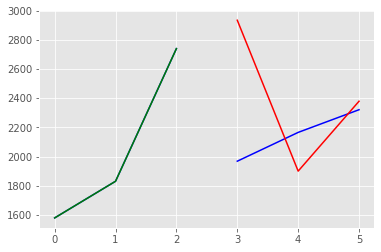

In [446]:
predictions21 = model21.predict(x_test21)
predictions_train21 = model21.predict(x_train21)

print(x_train21.shape)
print(y_train21.shape)
print(x_test21.shape)
print(y_test21.shape)
print(NN_PB_sku100.shape)

x2_21 = numpy.arange(0, 3, 1)
x3_21 = numpy.arange(3, 6, 1)

plt.plot(x2_21, y_train21, color='blue')
plt.plot(x2_21, predictions_train21, color='green')
plt.plot(x3_21, y_test21, color='blue')
plt.plot(x3_21, predictions21, color='red')

# redline - прогноз, greenline - подгонка

In [447]:
print(predictions21)

[[2937.1755]
 [1899.7407]
 [2380.338 ]]


In [ ]:
# -SKU#106-

In [475]:
PB_sku106 = df_for_PB.loc[(df_for_PB['sku_id'] == 'sku #106')]
PB_sku106.drop('sku_id', axis=1, inplace=True)
#PB_sku106.iloc[:,1].plot()

NN_PB_sku106 = pd.DataFrame()

for i in range(12,0,-1):
    NN_PB_sku106['t-' + str(i)] = PB_sku106.iloc[:,1].shift(i)
    
NN_PB_sku106['t'] = PB_sku106.iloc[:,1].values
#print(NN_PB_sku106.head(13))

new_NN_PB_sku106 = NN_PB_sku106[12:]
#new_NN_PB_sku106.head()

y22 = new_NN_PB_sku106['t']
x22 = new_NN_PB_sku106.drop('t', axis=1)

# ВЫБОРКА: На этoм моменте, определяем, на сколько месяцев будет предсказание
x_train22 = x22[:7]
y_train22 = y22[:7]
x_test22 = x22[7:]
y_test22 = y22[7:]

#print(new_NN_PB_sku106.shape)
#print(x_train22.shape)
#print(y_train22.shape)
#print(x_test22.shape)
#print(y_test22.shape)
#print(x_train22.head(5))

x_train22 = x_train22.values
y_train22 = y_train22.values
x_test22 = x_test22.values
y_test22 = y_test22.values

# NN

model22 = Sequential()
model22.add(Dense(6, input_dim=12, activation='relu'))
model22.add(Dense(1, activation='linear'))
model22.compile(loss=losses.mean_squared_error, optimizer='adam', metrics=['mape'])
model22.fit(x_train22, y_train22, epochs=300, batch_size=None)

Epoch 1/300
7/7 [==============================] - 11s 2s/step - loss: 2499244.0000 - mean_absolute_percentage_error: 95.2734
Epoch 2/300
7/7 [==============================] - 0s 1ms/step - loss: 2370045.5000 - mean_absolute_percentage_error: 92.3472
Epoch 3/300
7/7 [==============================] - 0s 997us/step - loss: 2245374.2500 - mean_absolute_percentage_error: 89.4282
Epoch 4/300
7/7 [==============================] - 0s 1ms/step - loss: 2117196.7500 - mean_absolute_percentage_error: 86.3959
Epoch 5/300
7/7 [==============================] - 0s 1ms/step - loss: 1993268.6250 - mean_absolute_percentage_error: 83.3623
Epoch 6/300
7/7 [==============================] - 0s 2ms/step - loss: 1874158.6250 - mean_absolute_percentage_error: 80.3374
Epoch 7/300
7/7 [==============================] - 0s 2ms/step - loss: 1759966.0000 - mean_absolute_percentage_error: 77.3248
Epoch 8/300
7/7 [==============================] - 0s 2ms/step - loss: 1650763.6250 - mean_absolute_percentage_error

Epoch 66/300
7/7 [==============================] - 0s 2ms/step - loss: 286490.4062 - mean_absolute_percentage_error: 29.6236
Epoch 67/300
7/7 [==============================] - 0s 4ms/step - loss: 284595.3750 - mean_absolute_percentage_error: 29.5272
Epoch 68/300
7/7 [==============================] - 0s 2ms/step - loss: 282695.1562 - mean_absolute_percentage_error: 29.4312
Epoch 69/300
7/7 [==============================] - 0s 2ms/step - loss: 280794.8438 - mean_absolute_percentage_error: 29.3352
Epoch 70/300
7/7 [==============================] - 0s 2ms/step - loss: 278898.8125 - mean_absolute_percentage_error: 29.2394
Epoch 71/300
7/7 [==============================] - 0s 1ms/step - loss: 277011.0312 - mean_absolute_percentage_error: 29.1436
Epoch 72/300
7/7 [==============================] - 0s 2ms/step - loss: 275134.8438 - mean_absolute_percentage_error: 29.0479
Epoch 73/300
7/7 [==============================] - 0s 2ms/step - loss: 273273.0625 - mean_absolute_percentage_error: 

Epoch 131/300
7/7 [==============================] - 0s 1ms/step - loss: 187336.7500 - mean_absolute_percentage_error: 23.5853
Epoch 132/300
7/7 [==============================] - 0s 1ms/step - loss: 186124.5781 - mean_absolute_percentage_error: 23.5047
Epoch 133/300
7/7 [==============================] - 0s 2ms/step - loss: 184920.8906 - mean_absolute_percentage_error: 23.4246
Epoch 134/300
7/7 [==============================] - 0s 2ms/step - loss: 183721.8281 - mean_absolute_percentage_error: 23.3446
Epoch 135/300
7/7 [==============================] - 0s 2ms/step - loss: 182535.4062 - mean_absolute_percentage_error: 23.2653
Epoch 136/300
7/7 [==============================] - 0s 1ms/step - loss: 181357.5312 - mean_absolute_percentage_error: 23.1864
Epoch 137/300
7/7 [==============================] - 0s 2ms/step - loss: 180184.2500 - mean_absolute_percentage_error: 23.1077
Epoch 138/300
7/7 [==============================] - 0s 2ms/step - loss: 179023.5000 - mean_absolute_percentage

Epoch 196/300
7/7 [==============================] - 0s 4ms/step - loss: 124930.9297 - mean_absolute_percentage_error: 18.9083
Epoch 197/300
7/7 [==============================] - 0s 1ms/step - loss: 124202.0547 - mean_absolute_percentage_error: 18.8432
Epoch 198/300
7/7 [==============================] - 0s 1ms/step - loss: 123479.1094 - mean_absolute_percentage_error: 18.7783
Epoch 199/300
7/7 [==============================] - 0s 2ms/step - loss: 122762.2734 - mean_absolute_percentage_error: 18.7136
Epoch 200/300
7/7 [==============================] - 0s 2ms/step - loss: 122051.2500 - mean_absolute_percentage_error: 18.6492
Epoch 201/300
7/7 [==============================] - 0s 2ms/step - loss: 121346.1094 - mean_absolute_percentage_error: 18.5850
Epoch 202/300
7/7 [==============================] - 0s 2ms/step - loss: 120648.3594 - mean_absolute_percentage_error: 18.5212
Epoch 203/300
7/7 [==============================] - 0s 1ms/step - loss: 119954.7656 - mean_absolute_percentage

Epoch 261/300
7/7 [==============================] - 0s 4ms/step - loss: 88148.5391 - mean_absolute_percentage_error: 16.1733
Epoch 262/300
7/7 [==============================] - 0s 1ms/step - loss: 87720.6328 - mean_absolute_percentage_error: 16.1383
Epoch 263/300
7/7 [==============================] - 0s 2ms/step - loss: 87296.0391 - mean_absolute_percentage_error: 16.1034
Epoch 264/300
7/7 [==============================] - 0s 3ms/step - loss: 86874.8750 - mean_absolute_percentage_error: 16.0686
Epoch 265/300
7/7 [==============================] - 0s 1ms/step - loss: 86457.1250 - mean_absolute_percentage_error: 16.0339
Epoch 266/300
7/7 [==============================] - 0s 2ms/step - loss: 86043.2578 - mean_absolute_percentage_error: 15.9993
Epoch 267/300
7/7 [==============================] - 0s 2ms/step - loss: 85632.0547 - mean_absolute_percentage_error: 15.9648
Epoch 268/300
7/7 [==============================] - 0s 1ms/step - loss: 85224.0000 - mean_absolute_percentage_error: 

In [472]:
scores22 = model22.evaluate(x_test22, y_test22)
y_pred22 = model22.predict(x_test22)

def smape(y_test22, y_pred22):
    return 100/len(y_test22) * np.sum(2 * np.abs(y_pred22 - y_test22) / (np.abs(y_test22) + np.abs(y_pred22)))

print(smape(y_test22, y_pred22))
# Подсчитали SMAPE

3/3 [==============================] - 4s 1s/step
91.53084621036221


(7, 12)
(7,)
(3, 12)
(3,)
(22, 13)


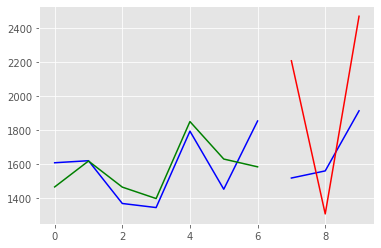

In [473]:
predictions22 = model22.predict(x_test22)
predictions_train22 = model22.predict(x_train22)

print(x_train22.shape)
print(y_train22.shape)
print(x_test22.shape)
print(y_test22.shape)
print(NN_PB_sku106.shape)

x2_22 = numpy.arange(0, 7, 1)
x3_22 = numpy.arange(7, 10, 1)

plt.plot(x2_22, y_train22, color='blue')
plt.plot(x2_22, predictions_train22, color='green')
plt.plot(x3_22, y_test22, color='blue')
plt.plot(x3_22, predictions22, color='red')

# redline - прогноз, greenline - подгонка

In [474]:
print(predictions22)

[[2208.7637]
 [1306.5388]
 [2471.2317]]
